'''

使用神经网络以图藏图”（NIPS2017），torch版本
paper：Hiding Images in Plain Sight:Deep Steganography 
https://papers.nips.cc/paper/2017/hash/838e8afb1ca34354ac209f53d90c3a43-Abstract.html

'''

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms,utils,datasets
from torch.utils.data import Dataset,DataLoader
import os
import numpy as np
from tqdm import *
import time
import random

In [3]:
#配置参数
#定义图像大小，是否需要随机裁剪
cropH = 64
cropW = 64
dataDir = "../data/tiny-imagenet-200/"
trainDir = os.path.join(dataDir,"train")
testDir = os.path.join(dataDir,"test")
batchSize = 64


In [5]:
# 选择3200个数据来训练
#加载数据集
def get_sub_data_loaders():
    
    sub_size = 3200
    
    data_transforms = {
        "train":transforms.Compose([
            transforms.RandomCrop((cropH,cropW),pad_if_needed=True),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ]),
        
        "test":transforms.Compose([
            transforms.CenterCrop((cropH,cropW)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
    }
    train_images = datasets.ImageFolder(trainDir,data_transforms["train"])
    indices_train = list(range(len(train_images)))
    indices_train = random.sample(indices_train,len(train_images))#按随机下标选取部分数据集
    sub_train_imgages = torch.utils.data.Subset(train_images, indices_train[:sub_size])    
    train_loader = DataLoader(sub_train_imgages,batch_size=batchSize,shuffle=True,drop_last =True,num_workers=4)
    
    test_images = datasets.ImageFolder(testDir,data_transforms["test"])
    indices_test = list(range(len(test_images)))
    indices_test = random.sample(indices_test,len(indices_test))#按随机下标选取部分数据集
    sub_test_imgages = torch.utils.data.Subset(train_images, indices_test[:sub_size])  
    test_loader = DataLoader(sub_test_imgages,batch_size=batchSize,shuffle=False,drop_last =True,num_workers=4)
    
    train_set_size = len(sub_train_imgages)
    test_set_size = len(sub_test_imgages)
    #print("type of train_images ",type(train_images))
    #print("type of train_loader ",type(train_loader))
    
    return train_loader,test_loader,train_set_size,test_set_size


train_images len =  3200
test_images len  =  3200
labels  tensor([ 68, 118,  46, 131, 108, 147, 100, 135, 109,  74, 196, 101,  62,  17,
        149, 163, 110, 172, 174, 147,  20,  32, 184, 115, 146,  38, 134,  70,
         96, 154,  42, 138, 137, 146,  81,  42, 141, 190,  64, 105, 113,  30,
        144,  85, 161,  76,  92,  77, 154,  62, 174,  62,  27, 120,  41, 113,
         34, 191,  70,  57, 107,  45,   0, 122])
images size =  torch.Size([64, 3, 64, 64])


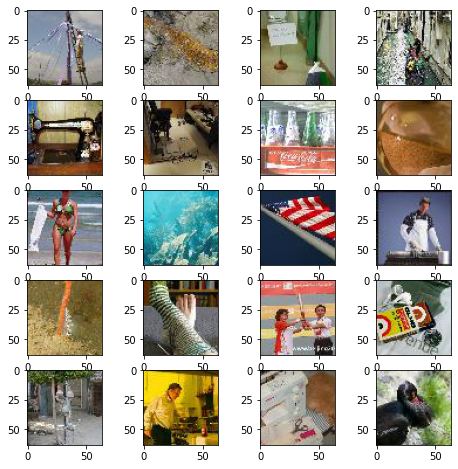

In [6]:
#随机显示一些图像
fig = plt.figure(figsize=(8,8)) #图像尺寸
colums = 4
rows = 5

#获取数据
train_loader,test_loader,train_set_size,test_set_size = get_sub_data_loaders()

print("train_images len = ",train_set_size)
print("test_images len  = ",test_set_size)
    
#随机获取一个batch的图像
dataiter = iter(train_loader)
images,labels = dataiter.next()
#print("images ",images)
print("labels ",labels)
print("images size = ",images.size())

for i in range(1,colums*rows+1):
    fig.add_subplot(rows,colums,i)
    #torch image 格式转换为 numpy image
    img = images[i]/2 +0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0))) # 维度转换
plt.show()

网络模型：整体是自编码器模型
prep Network：
将 input_S 转为特征图，如果尺寸小于 input_C ,准备网络会将特征图放大到同一尺寸，以便更均匀地嵌入到 input_C

Hiding Network：
经过多次实验，多种结构的网络，发现 50 个卷积核、卷积核大小分别为 3、4、5的网络效果最好。

Reveal Network：发现 50 个卷积核、卷积核大小分别为 3、4、5的网络.

注意图像输出层的激活函数是tanh，不是relu


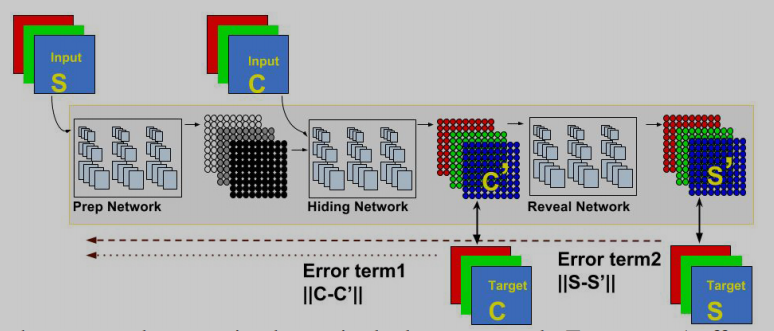

In [7]:
# 编写模型
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        # prep Network:先对密图S 进行两层卷积，每次卷积完的特征图进行融合
        self.conv1 = nn.Conv2d(3,50,3,padding = 1)
        self.conv2 = nn.Conv2d(3,10,4,padding = 1)
        self.conv3 = nn.Conv2d(3,5,5,padding = 2)
        
        self.conv4 = nn.Conv2d(65,50,3,padding = 1)
        self.conv5 = nn.Conv2d(65,10,4,padding = 1)
        self.conv6 = nn.Conv2d(65,5,5,padding = 2)
        
        #Hiding Network ：密图S在prep network 中的输出特征图，融合封面图片融合，并经过5层卷积
        # 原图3channel，密图65channel，故输入68个channel
        self.conv7 = nn.Conv2d(68,50,3,padding = 1)
        self.conv8 = nn.Conv2d(68,10,4,padding = 1)
        self.conv9 = nn.Conv2d(68,5,5,padding = 2)
        
        self.conv10 = nn.Conv2d(65,50,3,padding = 1)
        self.conv11 = nn.Conv2d(65,10,4,padding = 1)
        self.conv12 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv13 = nn.Conv2d(65,50,3,padding = 1)
        self.conv14 = nn.Conv2d(65,10,4,padding = 1)
        self.conv15 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv16 = nn.Conv2d(65,50,3,padding = 1)
        self.conv17 = nn.Conv2d(65,10,4,padding = 1)
        self.conv18 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv19 = nn.Conv2d(65,50,3,padding = 1)
        self.conv20 = nn.Conv2d(65,10,4,padding = 1)
        self.conv21 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv22 = nn.Conv2d(65,3,3,padding = 1)
        
    def forward(self,input_S,input_C):
        x1 = F.relu(self.conv1(input_S))
        x2 = F.relu(self.conv2(input_S))
            # kernel_size=4,卷积之后，高和宽的单位减 3 ，padding=1,之后，
            #四周加一条边，高和宽的单位加 2 ，但高和宽较原图任然缺 1 个单位,（0，1，0，1）表示在图像右下角加横纵两条边  
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv3(input_S))
        x4 = torch.cat((x1,x2,x3),1) # 特征图变厚,
        
        x1 = F.relu(self.conv4(x4))
        x2 = F.relu(self.conv5(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv6(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x4 = torch.cat((input_C,x4),1) 
        
            # 进入hiding network
        x1 = F.relu(self.conv7(x4))
        x2 = F.relu(self.conv8(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv9(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv10(x4))
        x2 = F.relu(self.conv11(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv12(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv13(x4))
        x2 = F.relu(self.conv14(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv15(x4))
        x4 = torch.cat((x1,x2,x3),1)  
        
        x1 = F.relu(self.conv16(x4))
        x2 = F.relu(self.conv17(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv18(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv19(x4))
        x2 = F.relu(self.conv20(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv21(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        #再进行一层卷积,输出3个channel（RBG）
        output = torch.tanh(self.conv22(x4))
        
        return output
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        #解码器，重建密图
        self.conv1 = nn.Conv2d(3,50,3,padding = 1)
        self.conv2 = nn.Conv2d(3,10,4,padding = 1)
        self.conv3 = nn.Conv2d(3,5,5,padding = 2)
        
        self.conv4 = nn.Conv2d(65,50,3,padding = 1)
        self.conv5 = nn.Conv2d(65,10,4,padding = 1)
        self.conv6 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv7 = nn.Conv2d(65,50,3,padding = 1)
        self.conv8 = nn.Conv2d(65,10,4,padding = 1)
        self.conv9 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv10 = nn.Conv2d(65,50,3,padding = 1)
        self.conv11 = nn.Conv2d(65,10,4,padding = 1)
        self.conv12 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv13 = nn.Conv2d(65,50,3,padding = 1)
        self.conv14 = nn.Conv2d(65,10,4,padding = 1)
        self.conv15 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv16 = nn.Conv2d(65,3,3,padding = 1)
    
    def forward(self,x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv3(x))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv4(x4))
        x2 = F.relu(self.conv5(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv6(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv7(x4))
        x2 = F.relu(self.conv8(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv9(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv10(x4))
        x2 = F.relu(self.conv11(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv12(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv13(x4))
        x2 = F.relu(self.conv14(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv15(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        output = torch.tanh(self.conv16(x4))
        
        return output

class Make_model(nn.Module):
    def __init__(self):
        super(Make_model,self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self,input_S,input_C):
        output_Cprime = self.encoder(input_S,input_C)
        output_Sprime = self.decoder(output_Cprime)
        
        return output_Cprime,output_Sprime
    
    

In [8]:
AEmodel =Make_model()
loss_history = []

In [9]:
# 训练

def train():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    #torch.cuda.set_device(1) #选择第二块显卡
    print("device : ",device)
    
    AEmodel.to(device)
    
    train_loader,test_loader,train_set_size,test_set_size = get_sub_data_loaders()
    
    
    # 定义损失函数
    S_mseloss = torch.nn.MSELoss().to(device) #计算密图重建损失
    C_mseloss = torch.nn.MSELoss().to(device) #计算明图重建损失
    
    optimizer = torch.optim.Adam(AEmodel.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9)
    loss_func = nn.CrossEntropyLoss().cuda()  # the target label is not one-hotted
    
    
    for epoch in range(1000):
        
        loss_all,c_loss,s_loss = [],[],[]
        t = tqdm(train_loader) #创建进度条,可直接用在迭代对象data_loader上
        
        for images, _ in t: 
            images = images.to(device) #数据发送到GPU，不然数据在cup上，格式不同
            AEmodel.train() #标记状态
            
            with torch.enable_grad():
                optimizer.zero_grad() #梯度清零
                
                # images 为一个batch的图像，分为明图和密图两部分
                input_C = images[0:images.shape[0] // 2]
                input_S = images[images.shape[0] // 2:]
            
                output_C,output_S = AEmodel(input_S,input_C)
                 
                #计算损失
                beta = 1.0
                ssLoss = S_mseloss(input_S,output_S)
                ccLoss = C_mseloss(input_C,output_C)
                loss =  beta * ssLoss + ccLoss
            
                loss.backward()
                optimizer.step()
            
                losses = {
                    "loss_all":loss.item(),
                    "ssLoss":ssLoss.item(),
                    "ccLoss":ccLoss.item()
                }
                loss_all.append(losses["loss_all"])
                c_loss.append(losses["ccLoss"])
                s_loss.append(losses["ssLoss"])
                
        loss_history.append(loss_all)
        print("[epoch = ",epoch+1,"] loss: ",np.mean(loss_all),"s_loss = ",np.mean(c_loss),"c_loss = ",np.mean(s_loss))
        
    

In [10]:
#%%capture output
train()

device :  cuda


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  1 ] loss:  0.40211737632751465 s_loss =  0.10427368141710758 c_loss =  0.2978436940908432


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  2 ] loss:  0.2925741690397263 s_loss =  0.06242768593132496 c_loss =  0.23014648377895355


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  3 ] loss:  0.1828233602643013 s_loss =  0.06589415319263935 c_loss =  0.11692920669913293


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  4 ] loss:  0.15369658440351486 s_loss =  0.05989693194627762 c_loss =  0.09379965171217919


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  5 ] loss:  0.12568274959921838 s_loss =  0.049840148091316226 c_loss =  0.07584260076284409


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  6 ] loss:  0.12159213557839393 s_loss =  0.048699033856391905 c_loss =  0.07289310082793236


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  7 ] loss:  0.10789041236042976 s_loss =  0.044583850912749766 c_loss =  0.06330656208097935


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  8 ] loss:  0.09973423779010773 s_loss =  0.04161127686500549 c_loss =  0.05812296070158482


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  9 ] loss:  0.095579993724823 s_loss =  0.036417427062988283 c_loss =  0.05916256681084633


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  10 ] loss:  0.0953372572362423 s_loss =  0.03645991895347834 c_loss =  0.05887733772397041


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  11 ] loss:  0.08304274082183838 s_loss =  0.03143489249050617 c_loss =  0.05160784773528576


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  12 ] loss:  0.0830707597732544 s_loss =  0.029206221885979176 c_loss =  0.05386453777551651


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  13 ] loss:  0.07519406504929066 s_loss =  0.027500741966068745 c_loss =  0.04769332267343998


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  14 ] loss:  0.0701745281368494 s_loss =  0.026549470238387586 c_loss =  0.043625057972967625


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  15 ] loss:  0.06610652416944504 s_loss =  0.027919241674244404 c_loss =  0.03818728223443031


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  16 ] loss:  0.05911242507398128 s_loss =  0.02668015465140343 c_loss =  0.032432270087301734


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  17 ] loss:  0.05555644311010838 s_loss =  0.025524543300271034 c_loss =  0.030031899474561214


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  18 ] loss:  0.05512136533856392 s_loss =  0.02442416988313198 c_loss =  0.030697195753455163


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  19 ] loss:  0.05803712971508503 s_loss =  0.026281503830105066 c_loss =  0.031755625754594806


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  20 ] loss:  0.05017575345933437 s_loss =  0.023715658728033304 c_loss =  0.02646009474992752


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  21 ] loss:  0.04868622183799744 s_loss =  0.022904495112597942 c_loss =  0.025781726874411107


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  22 ] loss:  0.046257177144289015 s_loss =  0.021379598770290612 c_loss =  0.024877578392624854


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  23 ] loss:  0.04435360860079527 s_loss =  0.021168431267142296 c_loss =  0.02318517740815878


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  24 ] loss:  0.04416039533913135 s_loss =  0.020742133632302283 c_loss =  0.023418261967599392


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  25 ] loss:  0.04085567403584719 s_loss =  0.01942969998344779 c_loss =  0.021425974033772947


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  26 ] loss:  0.043361370116472245 s_loss =  0.019929765816777946 c_loss =  0.023431604467332362


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  27 ] loss:  0.04214160367846489 s_loss =  0.020155878886580467 c_loss =  0.02198572490364313


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  28 ] loss:  0.04112985484302044 s_loss =  0.01974901732057333 c_loss =  0.021380837596952914


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  29 ] loss:  0.038543921932578086 s_loss =  0.018305062707513572 c_loss =  0.02023885916918516


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  30 ] loss:  0.04146234899759293 s_loss =  0.01968104861676693 c_loss =  0.021781300455331803


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  31 ] loss:  0.03684940159320831 s_loss =  0.018242002371698617 c_loss =  0.018607399202883245


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  32 ] loss:  0.035552024692296985 s_loss =  0.017579441778361796 c_loss =  0.01797258261591196


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  33 ] loss:  0.03689768929034472 s_loss =  0.017958917897194625 c_loss =  0.018938771355897187


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  34 ] loss:  0.036830404698848726 s_loss =  0.0181141253747046 c_loss =  0.018716279212385417


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  35 ] loss:  0.03580733198672533 s_loss =  0.017655373886227607 c_loss =  0.01815195830538869


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  36 ] loss:  0.03373026020824909 s_loss =  0.01731105299666524 c_loss =  0.01641920730471611


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  37 ] loss:  0.03342816531658173 s_loss =  0.01697417100891471 c_loss =  0.016453994158655404


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  38 ] loss:  0.033858722001314165 s_loss =  0.016923955250531433 c_loss =  0.016934766694903375


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  39 ] loss:  0.03377333667129278 s_loss =  0.01682826966047287 c_loss =  0.016945067215710877


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  40 ] loss:  0.032681849934160706 s_loss =  0.016270292457193136 c_loss =  0.016411557458341122


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  41 ] loss:  0.03599319487810135 s_loss =  0.017523372154682873 c_loss =  0.018469822853803636


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  42 ] loss:  0.039231527857482434 s_loss =  0.018471785932779313 c_loss =  0.020759741961956023


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  43 ] loss:  0.03319934129714966 s_loss =  0.017674920838326214 c_loss =  0.015524420291185378


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  44 ] loss:  0.0317371216788888 s_loss =  0.016320812311023475 c_loss =  0.015416309386491776


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  45 ] loss:  0.02997533205896616 s_loss =  0.015437251385301352 c_loss =  0.014538080580532551


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  46 ] loss:  0.03142198760062456 s_loss =  0.015626872666180135 c_loss =  0.015795114543288948


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  47 ] loss:  0.030604304224252702 s_loss =  0.015350337363779545 c_loss =  0.015253966711461543


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  48 ] loss:  0.03194674178957939 s_loss =  0.015660618506371973 c_loss =  0.016286123283207415


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  49 ] loss:  0.03098069317638874 s_loss =  0.014703009631484748 c_loss =  0.0162776836194098


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  50 ] loss:  0.037395404651761055 s_loss =  0.018471391815692188 c_loss =  0.018924012519419192


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  51 ] loss:  0.031156919188797472 s_loss =  0.015931426510214806 c_loss =  0.015225492548197508


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  52 ] loss:  0.0292201629281044 s_loss =  0.015286065936088562 c_loss =  0.013934097029268741


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  53 ] loss:  0.041454576551914216 s_loss =  0.01839522721245885 c_loss =  0.023059349227696656


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  54 ] loss:  0.03114708598703146 s_loss =  0.015235774777829647 c_loss =  0.015911311078816652


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  55 ] loss:  0.028305212706327437 s_loss =  0.014014803096652031 c_loss =  0.014290409591048957


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  56 ] loss:  0.029396392926573752 s_loss =  0.013533656671643256 c_loss =  0.015862736254930496


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  57 ] loss:  0.030051859728991985 s_loss =  0.014211546033620834 c_loss =  0.015840313956141473


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  58 ] loss:  0.028752700611948966 s_loss =  0.013281317092478276 c_loss =  0.0154713836312294


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  59 ] loss:  0.027888731248676777 s_loss =  0.013064901418983936 c_loss =  0.014823829866945743


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  60 ] loss:  0.02824825409799814 s_loss =  0.013230920396745205 c_loss =  0.015017333421856165


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  61 ] loss:  0.028051329888403417 s_loss =  0.013001370113343 c_loss =  0.0150499595887959


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  62 ] loss:  0.0298010740429163 s_loss =  0.013379491399973631 c_loss =  0.01642158258706331


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  63 ] loss:  0.026861828453838825 s_loss =  0.012625597417354584 c_loss =  0.014236230999231339


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  64 ] loss:  0.027653068639338016 s_loss =  0.01316283643245697 c_loss =  0.01449023213237524


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  65 ] loss:  0.026552166379988192 s_loss =  0.012105945385992528 c_loss =  0.014446221012622117


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  66 ] loss:  0.025447347983717918 s_loss =  0.011527928207069636 c_loss =  0.013919419683516026


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  67 ] loss:  0.027375229932367802 s_loss =  0.012613976616412401 c_loss =  0.014761253334581852


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  68 ] loss:  0.026455905959010123 s_loss =  0.01156989044509828 c_loss =  0.01488601552322507


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  69 ] loss:  0.024500510580837728 s_loss =  0.011305254036560655 c_loss =  0.013195256590843201


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  70 ] loss:  0.025302029587328433 s_loss =  0.011586812241002917 c_loss =  0.01371521731838584


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  71 ] loss:  0.02545888215303421 s_loss =  0.011181356366723776 c_loss =  0.01427752574905753


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  72 ] loss:  0.024427249357104303 s_loss =  0.011124566532671451 c_loss =  0.013302682861685754


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  73 ] loss:  0.026018114872276784 s_loss =  0.011453817579895258 c_loss =  0.01456429723650217


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  74 ] loss:  0.023363564535975455 s_loss =  0.010654745837673545 c_loss =  0.012708818577229976


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  75 ] loss:  0.02397129625082016 s_loss =  0.010884398724883795 c_loss =  0.013086897674947978


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  76 ] loss:  0.023593848384916783 s_loss =  0.010993110034614801 c_loss =  0.012600738294422627


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  77 ] loss:  0.02380975231528282 s_loss =  0.010597770791500807 c_loss =  0.013211981505155563


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  78 ] loss:  0.024733950458467005 s_loss =  0.011189866764470934 c_loss =  0.013544083666056394


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  79 ] loss:  0.025574819296598435 s_loss =  0.010802565971389413 c_loss =  0.014772253222763538


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  80 ] loss:  0.024015966802835464 s_loss =  0.010734181450679899 c_loss =  0.013281785398721695


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  81 ] loss:  0.023808164857327938 s_loss =  0.010924251284450293 c_loss =  0.012883913405239582


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  82 ] loss:  0.02282945202663541 s_loss =  0.010155871510505676 c_loss =  0.012673580581322312


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  83 ] loss:  0.024036772400140762 s_loss =  0.010420372458174825 c_loss =  0.013616400193423034


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  84 ] loss:  0.022764271534979345 s_loss =  0.010246790973469614 c_loss =  0.012517480608075858


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  85 ] loss:  0.02277655392885208 s_loss =  0.010200924165546894 c_loss =  0.012575629651546478


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  86 ] loss:  0.02324668824672699 s_loss =  0.010482858177274465 c_loss =  0.012763830013573169


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  87 ] loss:  0.020678145475685597 s_loss =  0.009818962290883065 c_loss =  0.010859183203428983


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  88 ] loss:  0.026553132236003876 s_loss =  0.011683623176068067 c_loss =  0.014869509041309356


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  89 ] loss:  0.02205989111214876 s_loss =  0.009751120721921325 c_loss =  0.012308770287781955


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  90 ] loss:  0.022096210923045874 s_loss =  0.009793545510619879 c_loss =  0.012302665505558252


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  91 ] loss:  0.02245747473090887 s_loss =  0.00975334462709725 c_loss =  0.012704130057245492


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  92 ] loss:  0.022198159843683243 s_loss =  0.010116218468174338 c_loss =  0.012081941328942776


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  93 ] loss:  0.022416608668863774 s_loss =  0.010333072040230035 c_loss =  0.012083536703139544


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  94 ] loss:  0.021728134863078594 s_loss =  0.009581275824457407 c_loss =  0.012146859038621187


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  95 ] loss:  0.0206227445974946 s_loss =  0.009257578626275062 c_loss =  0.011365165952593088


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  96 ] loss:  0.02372558642178774 s_loss =  0.010059041250497103 c_loss =  0.013666545115411282


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  97 ] loss:  0.02105751298367977 s_loss =  0.00950802314095199 c_loss =  0.011549489768221975


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  98 ] loss:  0.021448125578463078 s_loss =  0.009980323435738682 c_loss =  0.011467802161350847


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  99 ] loss:  0.022262605130672453 s_loss =  0.009659510776400567 c_loss =  0.012603094363585114


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  100 ] loss:  0.02301772404462099 s_loss =  0.009993795519694686 c_loss =  0.013023928552865983


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  101 ] loss:  0.021482048947364094 s_loss =  0.010037322081625461 c_loss =  0.011444726921617986


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  102 ] loss:  0.01931659031659365 s_loss =  0.009142648046836257 c_loss =  0.010173942055553198


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  103 ] loss:  0.019835643582046033 s_loss =  0.008931694142520428 c_loss =  0.010903949299827218


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  104 ] loss:  0.02277978703379631 s_loss =  0.009752930263057352 c_loss =  0.013026856714859605


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  105 ] loss:  0.02063187725841999 s_loss =  0.009641703981906176 c_loss =  0.010990173257887363


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  106 ] loss:  0.020135477911680938 s_loss =  0.00938204756937921 c_loss =  0.010753430221229791


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  107 ] loss:  0.01936385752633214 s_loss =  0.008844568179920315 c_loss =  0.010519289234653116


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  108 ] loss:  0.018695161044597626 s_loss =  0.008814042964950204 c_loss =  0.009881118088960647


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  109 ] loss:  0.020518043152987955 s_loss =  0.009005907904356718 c_loss =  0.011512135313823819


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  110 ] loss:  0.01859061824157834 s_loss =  0.008362155323848128 c_loss =  0.010228462973609567


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  111 ] loss:  0.01893347132951021 s_loss =  0.00855770919471979 c_loss =  0.01037576200440526


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  112 ] loss:  0.018911064434796572 s_loss =  0.008578860759735107 c_loss =  0.010332203628495336


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  113 ] loss:  0.019450681637972592 s_loss =  0.008822049740701913 c_loss =  0.010628631832078099


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  114 ] loss:  0.018406232818961143 s_loss =  0.008389190575107931 c_loss =  0.010017042271792889


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  115 ] loss:  0.019552241303026675 s_loss =  0.00914327021688223 c_loss =  0.010408971132710576


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  116 ] loss:  0.02116541502997279 s_loss =  0.008748075170442461 c_loss =  0.012417339878156781


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  117 ] loss:  0.022666555251926183 s_loss =  0.010640673935413361 c_loss =  0.012025881307199598


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  118 ] loss:  0.017919283527880907 s_loss =  0.008836991796270012 c_loss =  0.009082291638478637


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  119 ] loss:  0.018076492920517922 s_loss =  0.008371421471238136 c_loss =  0.009705071439966559


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  120 ] loss:  0.01917052308097482 s_loss =  0.008832206884399056 c_loss =  0.010338316252455116


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  121 ] loss:  0.01830341784283519 s_loss =  0.008146426500752568 c_loss =  0.010156991286203265


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  122 ] loss:  0.01854525363072753 s_loss =  0.00906531953252852 c_loss =  0.009479934023693204


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  123 ] loss:  0.018071155734360217 s_loss =  0.009055260512977838 c_loss =  0.009015895128250122


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  124 ] loss:  0.017781479768455028 s_loss =  0.008839477095752954 c_loss =  0.008942002663388848


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  125 ] loss:  0.017802074775099753 s_loss =  0.008726742230355739 c_loss =  0.009075332330539823


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  126 ] loss:  0.017106251548975705 s_loss =  0.008369785975664854 c_loss =  0.008736465647816659


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  127 ] loss:  0.022021690011024476 s_loss =  0.009088707184419035 c_loss =  0.012932982901111246


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  128 ] loss:  0.018484124541282655 s_loss =  0.008901820983737707 c_loss =  0.009582303697243333


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  129 ] loss:  0.016754229664802552 s_loss =  0.008420950705185533 c_loss =  0.008333278968930245


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  130 ] loss:  0.024535025004297495 s_loss =  0.010912021510303021 c_loss =  0.01362300332635641


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  131 ] loss:  0.018213508799672127 s_loss =  0.00885571955703199 c_loss =  0.009357789335772394


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  132 ] loss:  0.019264559783041476 s_loss =  0.008892409587278962 c_loss =  0.01037215013988316


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  133 ] loss:  0.016497513595968485 s_loss =  0.008625854160636664 c_loss =  0.007871659351512789


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  134 ] loss:  0.01654061758890748 s_loss =  0.00823376514017582 c_loss =  0.008306852411478757


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  135 ] loss:  0.016669453401118518 s_loss =  0.008090691175311804 c_loss =  0.008578762281686067


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  136 ] loss:  0.016191082075238228 s_loss =  0.008220635373145341 c_loss =  0.007970446748659014


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  137 ] loss:  0.015428552329540253 s_loss =  0.008123600529506803 c_loss =  0.007304951790720224


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  138 ] loss:  0.01641311325132847 s_loss =  0.008155243238434196 c_loss =  0.008257869984954596


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  139 ] loss:  0.018213038071990012 s_loss =  0.009259410351514816 c_loss =  0.008953627673909068


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  140 ] loss:  0.015065883584320545 s_loss =  0.008239356894046068 c_loss =  0.006826526625081897


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  141 ] loss:  0.01691999053582549 s_loss =  0.008418846148997546 c_loss =  0.0085011444427073


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  142 ] loss:  0.0176258110627532 s_loss =  0.008681715102866291 c_loss =  0.00894409597851336


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  143 ] loss:  0.017034959215670824 s_loss =  0.00891876420006156 c_loss =  0.00811619509011507


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  144 ] loss:  0.014836831428110599 s_loss =  0.007968764742836356 c_loss =  0.00686806658282876


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  145 ] loss:  0.016080812178552152 s_loss =  0.008144041439518333 c_loss =  0.007936770729720592


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  146 ] loss:  0.01609141528606415 s_loss =  0.008025404829531908 c_loss =  0.008066010372713208


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  147 ] loss:  0.015251360815018416 s_loss =  0.00823777550831437 c_loss =  0.007013585343956947


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  148 ] loss:  0.015074791777879 s_loss =  0.007913351710885762 c_loss =  0.00716144003905356


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  149 ] loss:  0.015498576108366252 s_loss =  0.008163162786513568 c_loss =  0.007335413405671716


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  150 ] loss:  0.015048532523214817 s_loss =  0.008098660968244076 c_loss =  0.006949871489778161


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  151 ] loss:  0.015391682144254445 s_loss =  0.008135649627074599 c_loss =  0.0072560324613004925


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  152 ] loss:  0.014337275233119727 s_loss =  0.00761071402579546 c_loss =  0.0067265611607581375


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  153 ] loss:  0.014287976529449225 s_loss =  0.007995312893763184 c_loss =  0.006292663579806686


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  154 ] loss:  0.016963105238974093 s_loss =  0.008813160229474306 c_loss =  0.008149945084005595


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  155 ] loss:  0.018378215562552213 s_loss =  0.00921700732782483 c_loss =  0.009161208346486092


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  156 ] loss:  0.015862798541784285 s_loss =  0.008712068488821388 c_loss =  0.007150730034336448


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  157 ] loss:  0.013939893133938312 s_loss =  0.007803245270624756 c_loss =  0.006136647835373879


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  158 ] loss:  0.013125589713454247 s_loss =  0.0074020598269999025 c_loss =  0.005723529886454344


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  159 ] loss:  0.01308763837441802 s_loss =  0.007349865268915892 c_loss =  0.0057377730496227745


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  160 ] loss:  0.015267293471843003 s_loss =  0.008287292290478945 c_loss =  0.006980001144111157


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  161 ] loss:  0.014380301292985677 s_loss =  0.007955556763336062 c_loss =  0.0064247445110231635


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  162 ] loss:  0.013089449498802424 s_loss =  0.007482323348522186 c_loss =  0.005607126173563301


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  163 ] loss:  0.014286225717514754 s_loss =  0.007382218912243843 c_loss =  0.006904006758704781


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  164 ] loss:  0.01763563085347414 s_loss =  0.009367454536259175 c_loss =  0.008268176270648837


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  165 ] loss:  0.014514535907655954 s_loss =  0.0078071154467761516 c_loss =  0.006707420400343836


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  166 ] loss:  0.01328606452792883 s_loss =  0.0076101956050843 c_loss =  0.005675868839025497


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  167 ] loss:  0.014187005572021008 s_loss =  0.007757063126191497 c_loss =  0.006429942492395639


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  168 ] loss:  0.013129624035209418 s_loss =  0.007499256413429975 c_loss =  0.005630367621779442


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  169 ] loss:  0.01427785038948059 s_loss =  0.007819907488301397 c_loss =  0.0064579428359866145


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  170 ] loss:  0.013913568798452616 s_loss =  0.008102387869730592 c_loss =  0.005811180854216218


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  171 ] loss:  0.014225904643535615 s_loss =  0.00784351136535406 c_loss =  0.0063823932781815525


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  172 ] loss:  0.012779967598617077 s_loss =  0.007505307663232088 c_loss =  0.005274659846909344


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  173 ] loss:  0.013973066657781601 s_loss =  0.007918286463245749 c_loss =  0.006054780180566013


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  174 ] loss:  0.01345028830692172 s_loss =  0.00736692788079381 c_loss =  0.00608336042612791


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  175 ] loss:  0.014192043673247098 s_loss =  0.0076976043544709685 c_loss =  0.0064944392675533895


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  176 ] loss:  0.013374370988458395 s_loss =  0.007540256148204207 c_loss =  0.005834114882163704


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  177 ] loss:  0.01312283992767334 s_loss =  0.007801125198602677 c_loss =  0.005321714710444212


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  178 ] loss:  0.014956456199288369 s_loss =  0.008074387712404131 c_loss =  0.006882068552076816


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  179 ] loss:  0.01247141746804118 s_loss =  0.007233235770836472 c_loss =  0.0052381816785782576


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  180 ] loss:  0.012713051680475474 s_loss =  0.007252159072086215 c_loss =  0.005460892571136355


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  181 ] loss:  0.013482598420232535 s_loss =  0.007615669965744019 c_loss =  0.0058669284777715805


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  182 ] loss:  0.013700965661555528 s_loss =  0.008208216847851873 c_loss =  0.005492748757824302


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  183 ] loss:  0.012842096164822578 s_loss =  0.007538889860734343 c_loss =  0.005303206271491945


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  184 ] loss:  0.012301385924220086 s_loss =  0.007203241977840662 c_loss =  0.005098143923096359


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  185 ] loss:  0.01429817259311676 s_loss =  0.007878101589158177 c_loss =  0.00642007103189826


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  186 ] loss:  0.013073723576962949 s_loss =  0.007660116925835609 c_loss =  0.00541360666975379


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  187 ] loss:  0.012677833754569292 s_loss =  0.007208189675584436 c_loss =  0.005469644092954695


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  188 ] loss:  0.013460060395300389 s_loss =  0.007515364931896329 c_loss =  0.005944695388898254


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  189 ] loss:  0.01290187431499362 s_loss =  0.0074340810906142 c_loss =  0.005467793205752969


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  190 ] loss:  0.013518145699054003 s_loss =  0.007700380929745734 c_loss =  0.005817764746025205


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  191 ] loss:  0.011675286963582039 s_loss =  0.007002388015389442 c_loss =  0.00467289901804179


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  192 ] loss:  0.01747305739670992 s_loss =  0.009037735350430011 c_loss =  0.008435322050936521


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  193 ] loss:  0.012850809823721648 s_loss =  0.007307561030611396 c_loss =  0.005543248755857349


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  194 ] loss:  0.011945213098078966 s_loss =  0.0072757701855152845 c_loss =  0.0046694428473711014


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  195 ] loss:  0.012566251903772354 s_loss =  0.007187119098380208 c_loss =  0.0053791327448561785


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  196 ] loss:  0.015608868524432183 s_loss =  0.008710495745763183 c_loss =  0.006898372815921903


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  197 ] loss:  0.013061847165226936 s_loss =  0.0077667894680053 c_loss =  0.005295057650655508


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  198 ] loss:  0.014130211677402258 s_loss =  0.008066309662535787 c_loss =  0.0060639019729569555


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  199 ] loss:  0.01220880500972271 s_loss =  0.007111756820231676 c_loss =  0.005097048142924904


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  200 ] loss:  0.011875349096953869 s_loss =  0.007200075834989547 c_loss =  0.004675273359753191


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  201 ] loss:  0.013952694889158011 s_loss =  0.007507666805759072 c_loss =  0.006445028115995228


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  202 ] loss:  0.013296023476868868 s_loss =  0.007733665201812983 c_loss =  0.005562358237802982


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  203 ] loss:  0.013389097861945629 s_loss =  0.007634057551622391 c_loss =  0.005755040310323239


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  204 ] loss:  0.012178727705031634 s_loss =  0.007584288083016873 c_loss =  0.004594439580105245


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  205 ] loss:  0.0141123366355896 s_loss =  0.00794517015106976 c_loss =  0.006167166484519839


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  206 ] loss:  0.012494209855794906 s_loss =  0.007051886660046875 c_loss =  0.005442323163151741


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  207 ] loss:  0.011290153097361326 s_loss =  0.006952888332307339 c_loss =  0.004337264741770923


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  208 ] loss:  0.013082354683429004 s_loss =  0.007906309887766838 c_loss =  0.005176044832915068


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  209 ] loss:  0.01190415539778769 s_loss =  0.006967162429355085 c_loss =  0.004936992973089218


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  210 ] loss:  0.014147710967808962 s_loss =  0.008006227286532521 c_loss =  0.006141483793035149


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  211 ] loss:  0.01201930033043027 s_loss =  0.00704613471403718 c_loss =  0.0049731656303629275


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  212 ] loss:  0.011357282269746066 s_loss =  0.007012326531112194 c_loss =  0.004344955724664032


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  213 ] loss:  0.011879068091511727 s_loss =  0.007027809899300337 c_loss =  0.004851258168928325


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  214 ] loss:  0.012065578401088715 s_loss =  0.0069909198954701424 c_loss =  0.005074658431112766


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  215 ] loss:  0.012730202972888946 s_loss =  0.007322584483772516 c_loss =  0.0054076185915619135


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  216 ] loss:  0.012551719788461924 s_loss =  0.0075354261323809625 c_loss =  0.00501629360485822


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  217 ] loss:  0.012620542161166669 s_loss =  0.0072858585696667436 c_loss =  0.005334683572873473


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  218 ] loss:  0.012758889477699995 s_loss =  0.007528665708377957 c_loss =  0.005230223680846393


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  219 ] loss:  0.011490345373749733 s_loss =  0.0070310007221996785 c_loss =  0.0044593446049839254


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  220 ] loss:  0.0145204018894583 s_loss =  0.007647251980379224 c_loss =  0.006873149783350527


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  221 ] loss:  0.012772352565079928 s_loss =  0.00766926996409893 c_loss =  0.005103082652203739


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  222 ] loss:  0.011793615240603685 s_loss =  0.0072421411331743 c_loss =  0.004551474079489708


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  223 ] loss:  0.01119011697359383 s_loss =  0.006885099527426064 c_loss =  0.004305017441511154


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  224 ] loss:  0.014145272308960557 s_loss =  0.007773676207289099 c_loss =  0.006371596180833876


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  225 ] loss:  0.011345316600054502 s_loss =  0.006952428873628378 c_loss =  0.00439288773573935


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  226 ] loss:  0.011373406518250704 s_loss =  0.006825416800566018 c_loss =  0.004547989652492106


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  227 ] loss:  0.010905319498851896 s_loss =  0.006718764938414097 c_loss =  0.004186554527841509


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  228 ] loss:  0.015696598496288062 s_loss =  0.008386146603152156 c_loss =  0.007310451865196228


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  229 ] loss:  0.011391614843159915 s_loss =  0.007063454054296017 c_loss =  0.004328160788863897


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  230 ] loss:  0.012277993224561214 s_loss =  0.007044794866815209 c_loss =  0.005233198311179877


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  231 ] loss:  0.011672325991094112 s_loss =  0.0068117791041731835 c_loss =  0.004860546835698187


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  232 ] loss:  0.010577743388712407 s_loss =  0.006678118268027901 c_loss =  0.0038996250880882146


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  233 ] loss:  0.013077213764190673 s_loss =  0.007453484628349542 c_loss =  0.005623729126527905


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  234 ] loss:  0.01146642565727234 s_loss =  0.0070861172024160625 c_loss =  0.004380308403633535


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  235 ] loss:  0.011774135762825608 s_loss =  0.006943408902734518 c_loss =  0.004830726743675768


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  236 ] loss:  0.014090408552438021 s_loss =  0.007917382894083858 c_loss =  0.00617302562110126


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  237 ] loss:  0.011311940606683493 s_loss =  0.006818738365545869 c_loss =  0.004493202217854559


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  238 ] loss:  0.011188635844737291 s_loss =  0.006380405938252807 c_loss =  0.0048082299251109364


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  239 ] loss:  0.011594547145068645 s_loss =  0.00724903007503599 c_loss =  0.004345517125912011


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  240 ] loss:  0.012371043879538775 s_loss =  0.0070012791082262995 c_loss =  0.005369764743372798


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  241 ] loss:  0.011575830969959497 s_loss =  0.006941756205633282 c_loss =  0.004634074778296054


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  242 ] loss:  0.010558241438120603 s_loss =  0.006627804543823004 c_loss =  0.003930436898954213


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  243 ] loss:  0.012844731342047453 s_loss =  0.007384877940639853 c_loss =  0.005459853415377438


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  244 ] loss:  0.012597135305404662 s_loss =  0.007662979438900947 c_loss =  0.004934155917726457


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  245 ] loss:  0.011860819421708585 s_loss =  0.007337825736030936 c_loss =  0.004522993648424745


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  246 ] loss:  0.010805806880816816 s_loss =  0.006686773356050253 c_loss =  0.004119033608585596


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  247 ] loss:  0.012171738259494304 s_loss =  0.006995423901826143 c_loss =  0.00517631440423429


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  248 ] loss:  0.0112511782720685 s_loss =  0.006657219883054495 c_loss =  0.004593958356417715


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  249 ] loss:  0.01100104182958603 s_loss =  0.006687984606251121 c_loss =  0.004313057269901038


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  250 ] loss:  0.010997673133388161 s_loss =  0.0067192896641790865 c_loss =  0.004278383390046656


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  251 ] loss:  0.01058932171203196 s_loss =  0.006580844898708165 c_loss =  0.004008476790040731


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  252 ] loss:  0.01450876794755459 s_loss =  0.00819606414064765 c_loss =  0.006312703681178391


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  253 ] loss:  0.01214307552203536 s_loss =  0.006925022159703076 c_loss =  0.005218053343705833


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  254 ] loss:  0.011615034248679877 s_loss =  0.007310045305639505 c_loss =  0.004304988915100694


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  255 ] loss:  0.010886794440448284 s_loss =  0.006785623505711555 c_loss =  0.004101170864887535


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  256 ] loss:  0.012624510321766138 s_loss =  0.007327846009284258 c_loss =  0.005296664261259139


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  257 ] loss:  0.011286524757742881 s_loss =  0.006944424347020686 c_loss =  0.0043421003734692935


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  258 ] loss:  0.01243916891515255 s_loss =  0.007309481715783477 c_loss =  0.005129687148146331


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  259 ] loss:  0.012301873043179512 s_loss =  0.007000723537057638 c_loss =  0.005301149422302842


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  260 ] loss:  0.014528994373977184 s_loss =  0.008397538103163243 c_loss =  0.006131456173025071


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  261 ] loss:  0.011214455850422382 s_loss =  0.006928120376542211 c_loss =  0.004286335376091302


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  262 ] loss:  0.0109635173343122 s_loss =  0.007073243418708444 c_loss =  0.0038902738923206927


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  263 ] loss:  0.010577850444242358 s_loss =  0.0065412639267742635 c_loss =  0.004036586517468094


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  264 ] loss:  0.011040190812200307 s_loss =  0.006850382694974542 c_loss =  0.004189808201044798


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  265 ] loss:  0.012808614149689675 s_loss =  0.0077308258600533005 c_loss =  0.005077788205817342


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  266 ] loss:  0.011716613173484802 s_loss =  0.007340714419260621 c_loss =  0.004375898791477084


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  267 ] loss:  0.010962809175252915 s_loss =  0.0068271914776414635 c_loss =  0.004135617692954838


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  268 ] loss:  0.011532555036246776 s_loss =  0.006775070615112781 c_loss =  0.0047574843559414146


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  269 ] loss:  0.011027754303067922 s_loss =  0.006694330973550678 c_loss =  0.004333423324860633


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  270 ] loss:  0.0137535844091326 s_loss =  0.007942875623703003 c_loss =  0.005810708743520081


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  271 ] loss:  0.011749632339924574 s_loss =  0.007204886963590979 c_loss =  0.0045447453996166585


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  272 ] loss:  0.011925960918888449 s_loss =  0.0070497829746454955 c_loss =  0.004876177944242954


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  273 ] loss:  0.010987565498799085 s_loss =  0.006970759574323892 c_loss =  0.0040168058313429355


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  274 ] loss:  0.011191194923594595 s_loss =  0.006804100330919027 c_loss =  0.004387094643898308


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  275 ] loss:  0.01039093429222703 s_loss =  0.006684937346726656 c_loss =  0.0037059969129040835


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  276 ] loss:  0.013063596133142709 s_loss =  0.00784546454437077 c_loss =  0.005218131560832262


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  277 ] loss:  0.010214648675173521 s_loss =  0.00646650830283761 c_loss =  0.0037481403537094594


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  278 ] loss:  0.010466262996196747 s_loss =  0.006486082691699266 c_loss =  0.003980180341750383


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  279 ] loss:  0.010332576604560018 s_loss =  0.00643122423440218 c_loss =  0.003901352328248322


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  280 ] loss:  0.010991262504830956 s_loss =  0.006914565367624164 c_loss =  0.004076697072014213


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  281 ] loss:  0.011665612086653709 s_loss =  0.0070322362426668405 c_loss =  0.004633375811390578


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  282 ] loss:  0.011103719603270293 s_loss =  0.006633458510041237 c_loss =  0.004470261135138571


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  283 ] loss:  0.010819569090381264 s_loss =  0.006736125228926539 c_loss =  0.004083443842828274


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  284 ] loss:  0.011593611361458898 s_loss =  0.006959804277867079 c_loss =  0.0046338070277124645


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  285 ] loss:  0.01011806983500719 s_loss =  0.006383959418162704 c_loss =  0.0037341103935614227


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  286 ] loss:  0.009969613747671247 s_loss =  0.006543845911510289 c_loss =  0.0034257678082212804


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  287 ] loss:  0.011343940161168575 s_loss =  0.006816574987024069 c_loss =  0.004527365127578378


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  288 ] loss:  0.010672300849109887 s_loss =  0.006657180404290557 c_loss =  0.004015120388939977


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  289 ] loss:  0.011660063788294792 s_loss =  0.006993294237181544 c_loss =  0.004666769420728087


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  290 ] loss:  0.010151243265718222 s_loss =  0.00665969802532345 c_loss =  0.003491545198485255


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  291 ] loss:  0.010690427077934146 s_loss =  0.006468810895457863 c_loss =  0.0042216162011027335


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  292 ] loss:  0.010949687017127872 s_loss =  0.006860149195417762 c_loss =  0.0040895378403365615


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  293 ] loss:  0.01115116223692894 s_loss =  0.0069141229521483185 c_loss =  0.00423703929875046


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  294 ] loss:  0.011392331756651402 s_loss =  0.006857482446357608 c_loss =  0.004534849305637181


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  295 ] loss:  0.01208086371421814 s_loss =  0.006746851457282901 c_loss =  0.0053340122615918514


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  296 ] loss:  0.011319300476461649 s_loss =  0.0072394314128905535 c_loss =  0.004079868975095451


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  297 ] loss:  0.010796299939975142 s_loss =  0.006802856996655464 c_loss =  0.00399344299454242


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  298 ] loss:  0.011152429077774285 s_loss =  0.006594918416813016 c_loss =  0.004557510600425303


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  299 ] loss:  0.010260893302038311 s_loss =  0.006435582046397031 c_loss =  0.003825311250984669


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  300 ] loss:  0.010013733301311731 s_loss =  0.00649849277921021 c_loss =  0.0035152404801920057


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  301 ] loss:  0.009991191299632192 s_loss =  0.00643989082891494 c_loss =  0.003551300480030477


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  302 ] loss:  0.010334192179143428 s_loss =  0.006487175482325256 c_loss =  0.0038470167061313986


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  303 ] loss:  0.01034850194118917 s_loss =  0.006234950167126953 c_loss =  0.0041135517507791515


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  304 ] loss:  0.01045627187937498 s_loss =  0.006735769482329488 c_loss =  0.003720502443611622


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  305 ] loss:  0.011335246777161957 s_loss =  0.006924039172008634 c_loss =  0.0044112075166776775


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  306 ] loss:  0.009789681043475867 s_loss =  0.006294759325683117 c_loss =  0.0034949217550456525


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  307 ] loss:  0.012771333130076527 s_loss =  0.007390880128368736 c_loss =  0.005380453001707792


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  308 ] loss:  0.010815380224958062 s_loss =  0.006774656567722559 c_loss =  0.004040723568759858


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  309 ] loss:  0.009963755989447235 s_loss =  0.006521144332364202 c_loss =  0.0034426116198301316


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  310 ] loss:  0.01002878307364881 s_loss =  0.006351462937891484 c_loss =  0.00367732014041394


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  311 ] loss:  0.009984244359657168 s_loss =  0.006287826145999134 c_loss =  0.0036964182043448092


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  312 ] loss:  0.012115139234811067 s_loss =  0.006932912450283765 c_loss =  0.005182226737961173


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  313 ] loss:  0.010981734795495867 s_loss =  0.006810209723189473 c_loss =  0.004171525030396878


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  314 ] loss:  0.011202907226979732 s_loss =  0.0068430393934249874 c_loss =  0.004359867898747325


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  315 ] loss:  0.010614421339705587 s_loss =  0.006788261933252215 c_loss =  0.0038261594204232097


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  316 ] loss:  0.010697014266625046 s_loss =  0.006906922818161547 c_loss =  0.0037900914903730154


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  317 ] loss:  0.011199143510311841 s_loss =  0.00662176342215389 c_loss =  0.004577380008995533


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  318 ] loss:  0.010329708531498909 s_loss =  0.00654797725379467 c_loss =  0.0037817312171682716


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  319 ] loss:  0.010041779531165957 s_loss =  0.006437778007239103 c_loss =  0.003604001523926854


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  320 ] loss:  0.010441715251654387 s_loss =  0.00658912954851985 c_loss =  0.0038525857077911494


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  321 ] loss:  0.00973415224812925 s_loss =  0.006248524226248264 c_loss =  0.003485627993941307


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  322 ] loss:  0.010042732749134302 s_loss =  0.006445525325834751 c_loss =  0.003597207376733422


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  323 ] loss:  0.00992521209642291 s_loss =  0.00624746011570096 c_loss =  0.00367775191552937


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  324 ] loss:  0.011929811518639326 s_loss =  0.006736438497900963 c_loss =  0.005193373011425137


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  325 ] loss:  0.009373477809131146 s_loss =  0.0063937105843797325 c_loss =  0.002979767168872058


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  326 ] loss:  0.01046270390972495 s_loss =  0.006721819872036576 c_loss =  0.00374088398180902


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  327 ] loss:  0.011158719975501299 s_loss =  0.006394650377333164 c_loss =  0.004764069612137973


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  328 ] loss:  0.010155417220667005 s_loss =  0.006736990390345454 c_loss =  0.0034184268629178405


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  329 ] loss:  0.01217629169113934 s_loss =  0.006965216025710106 c_loss =  0.005211075628176331


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  330 ] loss:  0.010555272614583373 s_loss =  0.006052051312290132 c_loss =  0.004503221237100661


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  331 ] loss:  0.010852071782574057 s_loss =  0.006930453013628721 c_loss =  0.003921618745662272


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  332 ] loss:  0.009297159491106868 s_loss =  0.006109432140365243 c_loss =  0.0031877272855490445


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  333 ] loss:  0.009474304830655455 s_loss =  0.006152136540040373 c_loss =  0.0033221682440489533


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  334 ] loss:  0.011257632207125425 s_loss =  0.0068327071098610755 c_loss =  0.004424925176426769


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  335 ] loss:  0.011149092866107822 s_loss =  0.0072313482593745 c_loss =  0.003917744560167194


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  336 ] loss:  0.010116877490654588 s_loss =  0.006317065539769828 c_loss =  0.003799811932258308


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  337 ] loss:  0.010354416901245713 s_loss =  0.006725747361779213 c_loss =  0.003628669478930533


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  338 ] loss:  0.00950539474375546 s_loss =  0.005912801013328135 c_loss =  0.003592593716457486


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  339 ] loss:  0.010872872285544873 s_loss =  0.006548365377821028 c_loss =  0.004324506907723844


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  340 ] loss:  0.009844240453094243 s_loss =  0.006494126049801707 c_loss =  0.0033501143380999564


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  341 ] loss:  0.00991853753104806 s_loss =  0.0062169415643438695 c_loss =  0.0037015959387645125


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  342 ] loss:  0.010252555031329394 s_loss =  0.006409940333105624 c_loss =  0.003842614688910544


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  343 ] loss:  0.009264121484011411 s_loss =  0.0060273552453145385 c_loss =  0.003236766206100583


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  344 ] loss:  0.011023935619741678 s_loss =  0.006696456968784332 c_loss =  0.004327478604391217


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  345 ] loss:  0.011057936772704124 s_loss =  0.007055208813399077 c_loss =  0.004002727898769081


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  346 ] loss:  0.009255176689475775 s_loss =  0.006111840936355293 c_loss =  0.0031433357298374176


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  347 ] loss:  0.010424066660925746 s_loss =  0.00652956570032984 c_loss =  0.0038945008721202614


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  348 ] loss:  0.010233916202560067 s_loss =  0.006234379303641617 c_loss =  0.003999536926858127


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  349 ] loss:  0.009385162480175496 s_loss =  0.006171464528888464 c_loss =  0.0032136978954076766


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  350 ] loss:  0.01013262233696878 s_loss =  0.006561938468366862 c_loss =  0.0035706838592886926


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  351 ] loss:  0.009682090878486633 s_loss =  0.0062714831624180074 c_loss =  0.0034106076834723355


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  352 ] loss:  0.010299449805170297 s_loss =  0.006676388448104262 c_loss =  0.0036230613198131325


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  353 ] loss:  0.00969656277447939 s_loss =  0.0064871526276692746 c_loss =  0.0032094101142138244


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  354 ] loss:  0.009783832216635346 s_loss =  0.006360267782583833 c_loss =  0.0034235644852742553


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  355 ] loss:  0.009952928898856043 s_loss =  0.006404556059278548 c_loss =  0.0035483727790415285


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  356 ] loss:  0.01042481755837798 s_loss =  0.006489748461171984 c_loss =  0.003935069073922932


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  357 ] loss:  0.011675729639828205 s_loss =  0.006836096150800585 c_loss =  0.004839633470401168


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  358 ] loss:  0.010500825373455883 s_loss =  0.0066500800428912045 c_loss =  0.003850745311938226


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  359 ] loss:  0.010610389187932015 s_loss =  0.0065963455010205506 c_loss =  0.004014043677598238


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  360 ] loss:  0.01033754245378077 s_loss =  0.006683274200186134 c_loss =  0.0036542682256549596


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  361 ] loss:  0.009424405079334975 s_loss =  0.006106936233118176 c_loss =  0.003317468799650669


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  362 ] loss:  0.010284797260537744 s_loss =  0.006196545697748661 c_loss =  0.0040882515721023084


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  363 ] loss:  0.009453616924583913 s_loss =  0.006389702968299389 c_loss =  0.003063913909718394


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  364 ] loss:  0.009970526872202755 s_loss =  0.006412502015009523 c_loss =  0.003558024815283716


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  365 ] loss:  0.011939308345317841 s_loss =  0.0069749749545007945 c_loss =  0.004964333246462047


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  366 ] loss:  0.009777973033487796 s_loss =  0.0061345240660011765 c_loss =  0.003643448888324201


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  367 ] loss:  0.010364704644307493 s_loss =  0.00620414646808058 c_loss =  0.004160558138974011


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  368 ] loss:  0.010054777087643742 s_loss =  0.006497285719960928 c_loss =  0.003557491400279105


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  369 ] loss:  0.00952929419465363 s_loss =  0.00644619139842689 c_loss =  0.0030831028381362556


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  370 ] loss:  0.009704766273498535 s_loss =  0.006196655165404082 c_loss =  0.0035081111127510667


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  371 ] loss:  0.00973015684634447 s_loss =  0.006247112872079015 c_loss =  0.0034830439928919075


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  372 ] loss:  0.009148835791274906 s_loss =  0.006094702668488026 c_loss =  0.0030541331553831695


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  373 ] loss:  0.010068543814122677 s_loss =  0.006508422149345279 c_loss =  0.003560121674090624


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  374 ] loss:  0.011205918835476041 s_loss =  0.006677407780662179 c_loss =  0.004528511054813862


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  375 ] loss:  0.010481932712718845 s_loss =  0.006639954689890146 c_loss =  0.0038419780461117626


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  376 ] loss:  0.011994407027959824 s_loss =  0.006638712845742702 c_loss =  0.005355694093741477


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  377 ] loss:  0.010124719999730587 s_loss =  0.0064100024476647375 c_loss =  0.003714717524126172


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  378 ] loss:  0.009490875881165267 s_loss =  0.006274680206552148 c_loss =  0.003216195651330054


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  379 ] loss:  0.012548470124602317 s_loss =  0.006841331999748945 c_loss =  0.005707138022407889


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  380 ] loss:  0.01052037394605577 s_loss =  0.006872280105017126 c_loss =  0.003648093813098967


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  381 ] loss:  0.009287994652986527 s_loss =  0.006126777301542461 c_loss =  0.003161217365413904


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  382 ] loss:  0.009045905210077762 s_loss =  0.006084233070723712 c_loss =  0.0029616721300408243


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  383 ] loss:  0.012795197758823634 s_loss =  0.007492570392787457 c_loss =  0.005302627384662628


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  384 ] loss:  0.009814586536958814 s_loss =  0.0064137446135282515 c_loss =  0.003400841858237982


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  385 ] loss:  0.00970285770483315 s_loss =  0.006617743289098144 c_loss =  0.003085114376153797


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  386 ] loss:  0.009071605261415244 s_loss =  0.00601887431461364 c_loss =  0.0030527309235185386


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  387 ] loss:  0.009258478619158269 s_loss =  0.0059627350326627495 c_loss =  0.0032957435585558416


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  388 ] loss:  0.009649070762097835 s_loss =  0.006264629624783993 c_loss =  0.0033844410977326334


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  389 ] loss:  0.009810599405318499 s_loss =  0.00632426097523421 c_loss =  0.0034863383462652563


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  390 ] loss:  0.009298782432451844 s_loss =  0.006377425203099847 c_loss =  0.0029213571711443364


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  391 ] loss:  0.011114591900259256 s_loss =  0.006674268273636699 c_loss =  0.004440323687158525


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  392 ] loss:  0.009962570676580072 s_loss =  0.0064205568842589855 c_loss =  0.003542013792321086


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  393 ] loss:  0.00949275861494243 s_loss =  0.006380997016094625 c_loss =  0.003111761584877968


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  394 ] loss:  0.00940935698337853 s_loss =  0.0060207949625328185 c_loss =  0.0033885619090870023


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  395 ] loss:  0.010129726333543658 s_loss =  0.006399263278581202 c_loss =  0.0037304630619473754


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  396 ] loss:  0.00967472198419273 s_loss =  0.006463275868445635 c_loss =  0.0032114459946751594


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  397 ] loss:  0.009205112587660552 s_loss =  0.006224730447866022 c_loss =  0.0029803821537643673


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  398 ] loss:  0.009196321433410048 s_loss =  0.0060581589257344606 c_loss =  0.0031381624937057494


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  399 ] loss:  0.010279948189854622 s_loss =  0.006439889390021563 c_loss =  0.0038400587020441888


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  400 ] loss:  0.010559230539947749 s_loss =  0.006788576287217438 c_loss =  0.003770654210820794


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  401 ] loss:  0.00936717770062387 s_loss =  0.006093303109519183 c_loss =  0.0032738746050745247


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  402 ] loss:  0.009461738634854555 s_loss =  0.006286456827074289 c_loss =  0.0031752817681990563


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  403 ] loss:  0.009187895357608795 s_loss =  0.006069215941242874 c_loss =  0.00311867939773947


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  404 ] loss:  0.009949876563623547 s_loss =  0.006458229003474116 c_loss =  0.003491647527553141


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  405 ] loss:  0.010046003339812159 s_loss =  0.0065563796926289795 c_loss =  0.003489623591303825


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  406 ] loss:  0.010024796519428492 s_loss =  0.0062635625712573525 c_loss =  0.003761233917903155


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  407 ] loss:  0.009362509325146675 s_loss =  0.006160986218601465 c_loss =  0.0032015230180695653


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  408 ] loss:  0.010160886151716113 s_loss =  0.0062084806943312285 c_loss =  0.003952405420131981


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  409 ] loss:  0.009500648276880384 s_loss =  0.006413663877174259 c_loss =  0.00308698435081169


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  410 ] loss:  0.010310806976631283 s_loss =  0.006740810074843466 c_loss =  0.0035699968598783016


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  411 ] loss:  0.008602838665246963 s_loss =  0.005791614134795964 c_loss =  0.002811224488541484


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  412 ] loss:  0.008998909275978803 s_loss =  0.005876164012588561 c_loss =  0.0031227452075108884


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  413 ] loss:  0.008946167659014464 s_loss =  0.006018091877922416 c_loss =  0.0029280758136883377


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  414 ] loss:  0.009954863488674163 s_loss =  0.006226386642083526 c_loss =  0.0037284768326207997


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  415 ] loss:  0.010065528005361557 s_loss =  0.006442206902429462 c_loss =  0.003623321109917015


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  416 ] loss:  0.009112660307437181 s_loss =  0.006168046901002526 c_loss =  0.002944613369181752


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  417 ] loss:  0.009874167498201131 s_loss =  0.006349380817264319 c_loss =  0.0035247866623103617


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  418 ] loss:  0.01041895148344338 s_loss =  0.006491387085989117 c_loss =  0.003927564355544746


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  419 ] loss:  0.009640918159857393 s_loss =  0.0062573239766061306 c_loss =  0.0033835941506549718


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  420 ] loss:  0.00953088529407978 s_loss =  0.006146672163158656 c_loss =  0.003384213123936206


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  421 ] loss:  0.009742144672200083 s_loss =  0.006349679064005614 c_loss =  0.00339246557559818


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  422 ] loss:  0.009276207648217677 s_loss =  0.006052235318347812 c_loss =  0.0032239722413942217


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  423 ] loss:  0.009655701583251358 s_loss =  0.006224602069705725 c_loss =  0.0034310995414853097


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  424 ] loss:  0.009410289078950883 s_loss =  0.00614661693572998 c_loss =  0.0032636721339076758


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  425 ] loss:  0.009396196641027928 s_loss =  0.006135612516663969 c_loss =  0.0032605841709300878


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  426 ] loss:  0.009347648490220309 s_loss =  0.005988237955607474 c_loss =  0.003359410520642996


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  427 ] loss:  0.009175418904051184 s_loss =  0.005966451857239008 c_loss =  0.003208967004902661


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  428 ] loss:  0.008794281138107181 s_loss =  0.005687788133509457 c_loss =  0.003106492990627885


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  429 ] loss:  0.010109691815450787 s_loss =  0.006212687091901898 c_loss =  0.0038970046723261474


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  430 ] loss:  0.009274209197610617 s_loss =  0.006217083055526018 c_loss =  0.003057126090861857


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  431 ] loss:  0.01087491356767714 s_loss =  0.006440396020188928 c_loss =  0.004434517500922084


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  432 ] loss:  0.008931297147646546 s_loss =  0.006189215141348541 c_loss =  0.0027420819853432475


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  433 ] loss:  0.008835275312885643 s_loss =  0.005918035069480538 c_loss =  0.0029172401782125235


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  434 ] loss:  0.010023583583533764 s_loss =  0.006239498127251863 c_loss =  0.003784085442312062


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  435 ] loss:  0.01014743502251804 s_loss =  0.0064575311914086345 c_loss =  0.0036899037659168243


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  436 ] loss:  0.008821805929765105 s_loss =  0.006089081182144582 c_loss =  0.0027327247359789906


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  437 ] loss:  0.010242173466831445 s_loss =  0.006293450924567878 c_loss =  0.003948722498025745


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  438 ] loss:  0.010900120371952654 s_loss =  0.007252442603930831 c_loss =  0.0036476777167990804


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  439 ] loss:  0.011376272421330214 s_loss =  0.0065774632897228 c_loss =  0.004798809047788382


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  440 ] loss:  0.01047478017397225 s_loss =  0.007086141603067518 c_loss =  0.0033886385383084415


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  441 ] loss:  0.009197487020865083 s_loss =  0.0060718745924532415 c_loss =  0.0031256124889478087


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  442 ] loss:  0.00903711144812405 s_loss =  0.006013994598761201 c_loss =  0.00302311681676656


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  443 ] loss:  0.009504927163943648 s_loss =  0.006375390943139792 c_loss =  0.0031295362231321634


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  444 ] loss:  0.00947692822664976 s_loss =  0.0063175862142816185 c_loss =  0.0031593420240096748


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  445 ] loss:  0.010680872946977615 s_loss =  0.006521237986162305 c_loss =  0.0041596349468454715


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  446 ] loss:  0.010490897642448545 s_loss =  0.006094431923702359 c_loss =  0.004396465653553605


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  447 ] loss:  0.009829215509817003 s_loss =  0.006798069863580167 c_loss =  0.0030311455996707083


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  448 ] loss:  0.009530135961249471 s_loss =  0.006142980828881264 c_loss =  0.0033871550764888523


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  449 ] loss:  0.009039073772728444 s_loss =  0.005958389369770885 c_loss =  0.003080684293527156


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  450 ] loss:  0.0108595488127321 s_loss =  0.006430321917869151 c_loss =  0.004429226852953434


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  451 ] loss:  0.009536478025838733 s_loss =  0.006407840047031641 c_loss =  0.003128637964837253


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  452 ] loss:  0.008831191388890148 s_loss =  0.006098194750957191 c_loss =  0.0027329966286197306


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  453 ] loss:  0.00952447253279388 s_loss =  0.006434868038631976 c_loss =  0.0030896044615656136


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  454 ] loss:  0.010645001493394375 s_loss =  0.006537227155640721 c_loss =  0.004107774221338332


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  455 ] loss:  0.008827521335333585 s_loss =  0.00597701202146709 c_loss =  0.0028505092579871414


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  456 ] loss:  0.010244537461549044 s_loss =  0.0064829130657017234 c_loss =  0.0037616243632510303


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  457 ] loss:  0.009768729079514742 s_loss =  0.006611953657120466 c_loss =  0.003156775487586856


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  458 ] loss:  0.009685418969020247 s_loss =  0.0062264945171773434 c_loss =  0.003458924451842904


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  459 ] loss:  0.009092015894129873 s_loss =  0.006081129810772836 c_loss =  0.0030108861066401003


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  460 ] loss:  0.008628091337159275 s_loss =  0.0059948720550164585 c_loss =  0.002633219324052334


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  461 ] loss:  0.009514850405976176 s_loss =  0.006169670857489109 c_loss =  0.003345179515890777


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  462 ] loss:  0.009085891842842102 s_loss =  0.006016295179724693 c_loss =  0.0030695965979248285


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  463 ] loss:  0.008757850928232074 s_loss =  0.005909089050255716 c_loss =  0.0028487618709914387


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  464 ] loss:  0.008673915900290012 s_loss =  0.005891148746013641 c_loss =  0.002782767117023468


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  465 ] loss:  0.008832854786887764 s_loss =  0.005898784906603396 c_loss =  0.0029340698570013046


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  466 ] loss:  0.009300194531679153 s_loss =  0.005961623266339302 c_loss =  0.003338571204803884


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  467 ] loss:  0.00822666408494115 s_loss =  0.005549317384138703 c_loss =  0.002677346682175994


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  468 ] loss:  0.008852391578257084 s_loss =  0.005918908859603107 c_loss =  0.0029334825626574457


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  469 ] loss:  0.00949673899449408 s_loss =  0.00593094892334193 c_loss =  0.0035657900059595706


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  470 ] loss:  0.009891479667276144 s_loss =  0.006294908225536347 c_loss =  0.0035965713998302815


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  471 ] loss:  0.00956801082007587 s_loss =  0.006270343977957964 c_loss =  0.003297666762955487


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  472 ] loss:  0.009378151735290885 s_loss =  0.006014034757390619 c_loss =  0.0033641170244663953


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  473 ] loss:  0.008670794330537319 s_loss =  0.00587324433028698 c_loss =  0.0027975499583408237


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  474 ] loss:  0.008509210888296365 s_loss =  0.005718475421890617 c_loss =  0.0027907354524359107


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  475 ] loss:  0.010044657615944743 s_loss =  0.00625869904179126 c_loss =  0.003785958597436547


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  476 ] loss:  0.009251862587407232 s_loss =  0.006216342020779848 c_loss =  0.00303552049677819


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  477 ] loss:  0.010058128293603658 s_loss =  0.006483927741646767 c_loss =  0.003574200617149472


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  478 ] loss:  0.008722110986709594 s_loss =  0.006028851214796305 c_loss =  0.0026932597276754676


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  479 ] loss:  0.00959960589185357 s_loss =  0.006251816535368561 c_loss =  0.003347789351828396


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  480 ] loss:  0.008801384242251515 s_loss =  0.005858953567221761 c_loss =  0.0029424306517466903


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  481 ] loss:  0.009774081520736217 s_loss =  0.006212937710806728 c_loss =  0.0035611437493935226


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  482 ] loss:  0.008981258319690823 s_loss =  0.0059913753904402255 c_loss =  0.0029898828873410823


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  483 ] loss:  0.008945514233782887 s_loss =  0.005946294590830803 c_loss =  0.002999219608027488


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  484 ] loss:  0.009120535291731357 s_loss =  0.005979251489043236 c_loss =  0.0031412838026881216


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  485 ] loss:  0.009006810765713453 s_loss =  0.006142732100561261 c_loss =  0.0028640786185860634


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  486 ] loss:  0.00966953401453793 s_loss =  0.006178598748520016 c_loss =  0.003490935256704688


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  487 ] loss:  0.008989981394261121 s_loss =  0.006094349501654506 c_loss =  0.002895631827414036


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  488 ] loss:  0.008585220286622643 s_loss =  0.005726965037174523 c_loss =  0.002858255268074572


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  489 ] loss:  0.009133875258266927 s_loss =  0.006121766683645546 c_loss =  0.003012108555994928


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  490 ] loss:  0.008875860637053846 s_loss =  0.0060171047504991295 c_loss =  0.0028587558888830246


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  491 ] loss:  0.009255554219707847 s_loss =  0.006011387007310987 c_loss =  0.0032441670680418613


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  492 ] loss:  0.00891845284961164 s_loss =  0.0055543613573536274 c_loss =  0.003364091543480754


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  493 ] loss:  0.00921369757503271 s_loss =  0.0059751058742403985 c_loss =  0.0032385916681960227


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  494 ] loss:  0.010010052723810076 s_loss =  0.006299941674806178 c_loss =  0.003710111044347286


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  495 ] loss:  0.009258033977821468 s_loss =  0.005969361700117588 c_loss =  0.003288672296330333


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  496 ] loss:  0.008896242575719953 s_loss =  0.006026508389040828 c_loss =  0.0028697341540828347


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  497 ] loss:  0.008637957582250238 s_loss =  0.005757259554229677 c_loss =  0.0028806980256922544


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  498 ] loss:  0.00896786998026073 s_loss =  0.006112006506882608 c_loss =  0.0028558634454384445


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  499 ] loss:  0.008789031067863107 s_loss =  0.005642321384511888 c_loss =  0.003146709664724767


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  500 ] loss:  0.009337940281257033 s_loss =  0.005985582559369504 c_loss =  0.0033523576753214


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  501 ] loss:  0.009182509165257216 s_loss =  0.0060370063735172156 c_loss =  0.0031455027963966133


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  502 ] loss:  0.009348647175356746 s_loss =  0.005932850600220263 c_loss =  0.003415796519257128


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  503 ] loss:  0.00853991936892271 s_loss =  0.0059714980190619825 c_loss =  0.002568421273026615


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  504 ] loss:  0.009164707688614725 s_loss =  0.005832590782083571 c_loss =  0.003332116901874542


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  505 ] loss:  0.01017378706485033 s_loss =  0.00646309582516551 c_loss =  0.0037106912350282073


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  506 ] loss:  0.00920026632025838 s_loss =  0.005819642040878534 c_loss =  0.0033806242607533933


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  507 ] loss:  0.008222046876326203 s_loss =  0.0056475899601355194 c_loss =  0.0025744569418020545


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  508 ] loss:  0.010300188474357128 s_loss =  0.006321693980135023 c_loss =  0.003978494452312588


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  509 ] loss:  0.008958344729617238 s_loss =  0.006057297680526972 c_loss =  0.0029010470677167176


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  510 ] loss:  0.009792587207630276 s_loss =  0.006492731678299606 c_loss =  0.003299855492077768


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  511 ] loss:  0.0082497036177665 s_loss =  0.00553212673868984 c_loss =  0.0027175768255256116


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  512 ] loss:  0.009143046252429485 s_loss =  0.005882178726606071 c_loss =  0.0032608674466609953


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  513 ] loss:  0.009061634810641407 s_loss =  0.006117493873462081 c_loss =  0.0029441409674473107


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  514 ] loss:  0.009568894961848855 s_loss =  0.006006957115605473 c_loss =  0.003561937848571688


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  515 ] loss:  0.008136997176334261 s_loss =  0.005541922836564481 c_loss =  0.0025950742815621197


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  516 ] loss:  0.008651398485526443 s_loss =  0.005681767296046018 c_loss =  0.0029696311708539724


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  517 ] loss:  0.009119217302650213 s_loss =  0.005924465414136648 c_loss =  0.003194751876872033


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  518 ] loss:  0.008759914059191942 s_loss =  0.005943303084932267 c_loss =  0.0028166109160520135


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  519 ] loss:  0.009461937518790365 s_loss =  0.00585575548466295 c_loss =  0.003606182055082172


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  520 ] loss:  0.01077190563082695 s_loss =  0.006490151109173894 c_loss =  0.00428175444714725


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  521 ] loss:  0.010358903827145695 s_loss =  0.0065159713290631775 c_loss =  0.003842932507395744


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  522 ] loss:  0.009849872766062617 s_loss =  0.006778720319271087 c_loss =  0.0030711524840444327


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  523 ] loss:  0.008775539267808198 s_loss =  0.006126842750236392 c_loss =  0.0026486964849755166


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  524 ] loss:  0.008738501407206058 s_loss =  0.0059380522090941665 c_loss =  0.002800449123606086


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  525 ] loss:  0.00863793993368745 s_loss =  0.00600596075411886 c_loss =  0.002631979153957218


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  526 ] loss:  0.008577670715749264 s_loss =  0.005756100034341216 c_loss =  0.0028215706697665155


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  527 ] loss:  0.009410498626530171 s_loss =  0.006345702204853297 c_loss =  0.0030647963332012295


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  528 ] loss:  0.008383468305692077 s_loss =  0.00591102740727365 c_loss =  0.002472440833225846


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  529 ] loss:  0.009021763335913419 s_loss =  0.005990101820789278 c_loss =  0.0030316614196635784


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  530 ] loss:  0.008734305696561933 s_loss =  0.005909872264601291 c_loss =  0.00282443342031911


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  531 ] loss:  0.008679557945579291 s_loss =  0.005773479724302888 c_loss =  0.002906078149098903


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  532 ] loss:  0.008939854279160499 s_loss =  0.005703619532287121 c_loss =  0.0032362347492016852


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  533 ] loss:  0.008786379657685757 s_loss =  0.006119361706078052 c_loss =  0.0026670179376378656


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  534 ] loss:  0.010315878428518771 s_loss =  0.0062298821611329915 c_loss =  0.004085996244102716


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  535 ] loss:  0.009317206777632236 s_loss =  0.006144257206469775 c_loss =  0.0031729495991021394


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  536 ] loss:  0.008623371059074998 s_loss =  0.00585684753023088 c_loss =  0.0027665235265158118


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  537 ] loss:  0.008605083040893078 s_loss =  0.006028894297778606 c_loss =  0.0025761887198314072


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  538 ] loss:  0.009974145144224168 s_loss =  0.006264625652693212 c_loss =  0.0037095194053836165


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  539 ] loss:  0.008474437659606338 s_loss =  0.005949742216616869 c_loss =  0.0025246954476460816


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  540 ] loss:  0.00852914578281343 s_loss =  0.005568560631945729 c_loss =  0.0029605851485393943


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  541 ] loss:  0.009036664981395007 s_loss =  0.0060124071128666405 c_loss =  0.003024257917422801


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  542 ] loss:  0.009895398169755936 s_loss =  0.006041982620954514 c_loss =  0.0038534154882654548


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  543 ] loss:  0.008844342418015003 s_loss =  0.006076677562668919 c_loss =  0.002767664832063019


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  544 ] loss:  0.009158652108162642 s_loss =  0.005989566300995648 c_loss =  0.0031690857047215106


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  545 ] loss:  0.009558785911649466 s_loss =  0.0065459508914500475 c_loss =  0.003012834987603128


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  546 ] loss:  0.008982244497165084 s_loss =  0.006125374254770577 c_loss =  0.0028568701958283783


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  547 ] loss:  0.008375240257009864 s_loss =  0.005934371910989285 c_loss =  0.0024408682622015475


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  548 ] loss:  0.008770558647811413 s_loss =  0.005782506261020899 c_loss =  0.0029880523518659176


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  549 ] loss:  0.009808428138494491 s_loss =  0.006205487549304962 c_loss =  0.003602940565906465


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  550 ] loss:  0.008666424900293351 s_loss =  0.00590767159126699 c_loss =  0.0027587532997131346


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  551 ] loss:  0.007904945313930512 s_loss =  0.005408383309841156 c_loss =  0.002496561943553388


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  552 ] loss:  0.009337211009114981 s_loss =  0.0060275923553854225 c_loss =  0.0033096185931935905


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  553 ] loss:  0.009213119596242905 s_loss =  0.005732227708213031 c_loss =  0.0034808919206261637


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  554 ] loss:  0.009765694690868259 s_loss =  0.005973817338235677 c_loss =  0.003791877334006131


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  555 ] loss:  0.010603324072435498 s_loss =  0.006312571000307798 c_loss =  0.004290753109380603


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  556 ] loss:  0.008917421773076058 s_loss =  0.005831661596894264 c_loss =  0.0030857601622119547


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  557 ] loss:  0.008509892374277114 s_loss =  0.0057493282575160265 c_loss =  0.0027605641074478627


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  558 ] loss:  0.008016785671934486 s_loss =  0.005345411347225309 c_loss =  0.0026713742851279675


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  559 ] loss:  0.008964248113334178 s_loss =  0.00583403144031763 c_loss =  0.003130216661375016


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  560 ] loss:  0.008289495585486292 s_loss =  0.005504131885245443 c_loss =  0.0027853636792860926


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  561 ] loss:  0.009726894591003656 s_loss =  0.006081389668397605 c_loss =  0.003645504873711616


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  562 ] loss:  0.009036684511229395 s_loss =  0.00596608882304281 c_loss =  0.003070595688186586


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  563 ] loss:  0.00886065324768424 s_loss =  0.005698805656284094 c_loss =  0.0031618475262075664


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  564 ] loss:  0.008195111295208335 s_loss =  0.005756380190141499 c_loss =  0.0024387311562895776


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  565 ] loss:  0.008358692154288291 s_loss =  0.0056133218202739955 c_loss =  0.0027453703503124414


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  566 ] loss:  0.009203398050740361 s_loss =  0.006078699603676796 c_loss =  0.0031246984330937267


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  567 ] loss:  0.008483571773394942 s_loss =  0.005687861489132046 c_loss =  0.002795710291247815


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  568 ] loss:  0.00847777291201055 s_loss =  0.005392204863019287 c_loss =  0.0030855680350214245


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  569 ] loss:  0.007728752605617046 s_loss =  0.00526121383998543 c_loss =  0.002467538753990084


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  570 ] loss:  0.007841903772205115 s_loss =  0.005433180443942547 c_loss =  0.002408723302651197


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  571 ] loss:  0.009335575439035893 s_loss =  0.00598174586892128 c_loss =  0.003353829518891871


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  572 ] loss:  0.009350741663947702 s_loss =  0.005644337846897543 c_loss =  0.0037064038217067717


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  573 ] loss:  0.00788065468892455 s_loss =  0.0053660463122650985 c_loss =  0.0025146083650179206


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  574 ] loss:  0.007953073913231492 s_loss =  0.005422093952074647 c_loss =  0.0025309799262322485


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  575 ] loss:  0.008420270271599292 s_loss =  0.005834857812151313 c_loss =  0.002585412443149835


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  576 ] loss:  0.008872918495908379 s_loss =  0.005898102787323296 c_loss =  0.002974815699271858


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  577 ] loss:  0.008421128941699862 s_loss =  0.005599890691228211 c_loss =  0.002821238194592297


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  578 ] loss:  0.008767865179106594 s_loss =  0.005297780502587557 c_loss =  0.0034700847533531485


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  579 ] loss:  0.00872378575615585 s_loss =  0.005836005075834692 c_loss =  0.00288778065238148


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  580 ] loss:  0.009118776945397257 s_loss =  0.00565840947907418 c_loss =  0.003460367424413562


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  581 ] loss:  0.008515020357444883 s_loss =  0.005923606958240271 c_loss =  0.002591413345653564


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  582 ] loss:  0.008562128683552146 s_loss =  0.005543931857682764 c_loss =  0.0030181968165561555


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  583 ] loss:  0.008185813650488854 s_loss =  0.005543052228167653 c_loss =  0.002642761350143701


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  584 ] loss:  0.008604460312053561 s_loss =  0.005852585337124765 c_loss =  0.0027518749632872643


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  585 ] loss:  0.00846133085899055 s_loss =  0.005478572691790759 c_loss =  0.0029827581206336618


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  586 ] loss:  0.008619523523375392 s_loss =  0.005762270102277398 c_loss =  0.0028572533745318653


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  587 ] loss:  0.00829099484719336 s_loss =  0.005427863318473101 c_loss =  0.002863131514750421


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  588 ] loss:  0.008114131493493914 s_loss =  0.005610416228882968 c_loss =  0.002503715252969414


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  589 ] loss:  0.008626298671588302 s_loss =  0.005532047324813902 c_loss =  0.003094251228030771


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  590 ] loss:  0.007634449796751141 s_loss =  0.005218132892623544 c_loss =  0.0024163169087842106


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  591 ] loss:  0.009001944297924638 s_loss =  0.005790632581338286 c_loss =  0.00321131166536361


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  592 ] loss:  0.008178663812577725 s_loss =  0.00539886109996587 c_loss =  0.002779802675358951


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  593 ] loss:  0.008452719291672111 s_loss =  0.005538041573017836 c_loss =  0.0029146776557900014


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  594 ] loss:  0.010007673650979996 s_loss =  0.006349980421364307 c_loss =  0.003657693206332624


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  595 ] loss:  0.008773018373176455 s_loss =  0.006054159393534065 c_loss =  0.002718859000597149


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  596 ] loss:  0.009785066619515418 s_loss =  0.006096023041754961 c_loss =  0.0036890435474924745


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  597 ] loss:  0.00841667908243835 s_loss =  0.005775025119073689 c_loss =  0.0026416539889760316


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  598 ] loss:  0.007726805973798037 s_loss =  0.005373832155019045 c_loss =  0.0023529737908393146


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  599 ] loss:  0.00878994789905846 s_loss =  0.005778865865431726 c_loss =  0.0030110820522531866


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  600 ] loss:  0.00796562422066927 s_loss =  0.005550845451653004 c_loss =  0.002414778743404895


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  601 ] loss:  0.007892304547131062 s_loss =  0.005398109168745577 c_loss =  0.002494195345789194


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  602 ] loss:  0.010943986317142844 s_loss =  0.006794099677354098 c_loss =  0.004149886616505683


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  603 ] loss:  0.008623961191624403 s_loss =  0.005705992891453206 c_loss =  0.00291796829784289


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  604 ] loss:  0.008659224743023514 s_loss =  0.0057881800876930355 c_loss =  0.0028710446087643502


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  605 ] loss:  0.008399512600153685 s_loss =  0.005653939796611667 c_loss =  0.0027455727849155665


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  606 ] loss:  0.008083543898537755 s_loss =  0.00536090181209147 c_loss =  0.0027226420724764467


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  607 ] loss:  0.008598642619326712 s_loss =  0.005337403113953769 c_loss =  0.0032612395077012478


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  608 ] loss:  0.008392054792493582 s_loss =  0.005532635706476868 c_loss =  0.002859419076703489


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  609 ] loss:  0.00830700802616775 s_loss =  0.00562480048276484 c_loss =  0.00268220754340291


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  610 ] loss:  0.009038116531446577 s_loss =  0.005720615703612566 c_loss =  0.0033175007766112685


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  611 ] loss:  0.008113489663228392 s_loss =  0.005404688189737499 c_loss =  0.002708801452536136


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  612 ] loss:  0.007782414080575109 s_loss =  0.005374263343401253 c_loss =  0.002408150718547404


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  613 ] loss:  0.008058278625831007 s_loss =  0.005361457183025778 c_loss =  0.0026968214311636983


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  614 ] loss:  0.007876061284914613 s_loss =  0.005431564259342849 c_loss =  0.002444496979005635


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  615 ] loss:  0.010172827234491706 s_loss =  0.005674047344364226 c_loss =  0.004498779899440706


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  616 ] loss:  0.008679909752681852 s_loss =  0.005712423888035119 c_loss =  0.0029674858856014908


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  617 ] loss:  0.009330587638542056 s_loss =  0.005946103441528976 c_loss =  0.0033844841318205


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  618 ] loss:  0.008633999060839415 s_loss =  0.005686651696451008 c_loss =  0.002947347341105342


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  619 ] loss:  0.008347174292430282 s_loss =  0.005651537044905126 c_loss =  0.002695637242868543


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  620 ] loss:  0.007875379538163543 s_loss =  0.005587304988875985 c_loss =  0.0022880745329894123


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  621 ] loss:  0.008127636844292283 s_loss =  0.0054539230372756715 c_loss =  0.002673713844269514


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  622 ] loss:  0.01343220860697329 s_loss =  0.007871806784532965 c_loss =  0.0055604016873985525


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  623 ] loss:  0.011827667262405157 s_loss =  0.007188652479089797 c_loss =  0.004639014853164553


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  624 ] loss:  0.009541058642789722 s_loss =  0.006229810984805227 c_loss =  0.0033112476114183663


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  625 ] loss:  0.008968388559296728 s_loss =  0.006099455105140805 c_loss =  0.002868933384306729


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  626 ] loss:  0.008748290613293647 s_loss =  0.005880392580293119 c_loss =  0.0028678980306722224


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  627 ] loss:  0.008219399591907858 s_loss =  0.005472788470797241 c_loss =  0.0027466110675595703


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  628 ] loss:  0.00786501243710518 s_loss =  0.005342297754250467 c_loss =  0.002522714608348906


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  629 ] loss:  0.009393779262900352 s_loss =  0.005824027988128364 c_loss =  0.003569751256145537


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  630 ] loss:  0.009844636209309102 s_loss =  0.006738721900619566 c_loss =  0.003105914224870503


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  631 ] loss:  0.008061304790899157 s_loss =  0.005686998730525374 c_loss =  0.0023743060254491867


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  632 ] loss:  0.008168521216139197 s_loss =  0.005319799347780645 c_loss =  0.0028487218543887137


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  633 ] loss:  0.008195436531677843 s_loss =  0.005514864888973534 c_loss =  0.002680571675300598


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  634 ] loss:  0.008542257007211446 s_loss =  0.005677754632197321 c_loss =  0.0028645023633725943


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  635 ] loss:  0.007951491242274643 s_loss =  0.005384322637692094 c_loss =  0.0025671686162240803


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  636 ] loss:  0.007719704695045948 s_loss =  0.005170399760827422 c_loss =  0.0025493049155920744


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  637 ] loss:  0.008212005561217666 s_loss =  0.005268353237770498 c_loss =  0.0029436522675678136


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  638 ] loss:  0.008269476210698486 s_loss =  0.00535834691952914 c_loss =  0.0029111292492598295


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  639 ] loss:  0.008533338634297252 s_loss =  0.00560484922491014 c_loss =  0.0029284894233569505


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  640 ] loss:  0.008278973465785384 s_loss =  0.005557728903368115 c_loss =  0.00272124448325485


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  641 ] loss:  0.008645263090729714 s_loss =  0.005528314053080976 c_loss =  0.003116949005052447


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  642 ] loss:  0.008218940030783415 s_loss =  0.00570496276486665 c_loss =  0.0025139772216789423


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  643 ] loss:  0.0077188067138195034 s_loss =  0.00523877075407654 c_loss =  0.0024800359969958663


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  644 ] loss:  0.008223697897046805 s_loss =  0.005572346611879766 c_loss =  0.0026513512642122807


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  645 ] loss:  0.008316820506006479 s_loss =  0.00540827845223248 c_loss =  0.0029085420281626286


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  646 ] loss:  0.008129002321511506 s_loss =  0.005668719531968236 c_loss =  0.0024602827429771423


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  647 ] loss:  0.007753437561914325 s_loss =  0.005123967449180782 c_loss =  0.002629470080137253


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  648 ] loss:  0.008753066407516599 s_loss =  0.005610451474785805 c_loss =  0.0031426148721948265


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  649 ] loss:  0.008031032951548696 s_loss =  0.005280668330378831 c_loss =  0.002750364583916962


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  650 ] loss:  0.008107378492131828 s_loss =  0.005334504051133991 c_loss =  0.0027728743967600166


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  651 ] loss:  0.008033582763746381 s_loss =  0.0053365333518013355 c_loss =  0.002697049353737384


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  652 ] loss:  0.008531725499778986 s_loss =  0.005526126492768526 c_loss =  0.0030055990628898143


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  653 ] loss:  0.009482074519619346 s_loss =  0.0058919857209548355 c_loss =  0.0035900887614116073


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  654 ] loss:  0.008516369964927434 s_loss =  0.005703460508957505 c_loss =  0.0028129093837924303


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  655 ] loss:  0.007963226111605763 s_loss =  0.005481115733273327 c_loss =  0.0024821103597059847


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  656 ] loss:  0.007838810840621591 s_loss =  0.005237553506158292 c_loss =  0.002601257301867008


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  657 ] loss:  0.007778365518897772 s_loss =  0.0052482698205858465 c_loss =  0.0025300957076251507


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  658 ] loss:  0.007349323248490691 s_loss =  0.0049535649502649905 c_loss =  0.0023957582493312657


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  659 ] loss:  0.013740690601989626 s_loss =  0.00623181379865855 c_loss =  0.007508876821957528


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  660 ] loss:  0.012181051094084978 s_loss =  0.007252960046753287 c_loss =  0.0049280909914523365


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  661 ] loss:  0.008462956976145505 s_loss =  0.005546944178640842 c_loss =  0.0029160127602517604


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  662 ] loss:  0.008445558808743954 s_loss =  0.005624679303728044 c_loss =  0.002820879481732845


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  663 ] loss:  0.008422520738095044 s_loss =  0.0056375460047274825 c_loss =  0.002784974714741111


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  664 ] loss:  0.007834810772910714 s_loss =  0.00553606528788805 c_loss =  0.002298745419830084


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  665 ] loss:  0.009491190817207097 s_loss =  0.005849813418462873 c_loss =  0.003641377401072532


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  666 ] loss:  0.008006301037967204 s_loss =  0.005309153124690056 c_loss =  0.0026971479365602135


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  667 ] loss:  0.007864671964198352 s_loss =  0.005502193784341216 c_loss =  0.002362478191498667


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  668 ] loss:  0.00795937561430037 s_loss =  0.005470989961177111 c_loss =  0.0024883856205269693


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  669 ] loss:  0.007687834510579705 s_loss =  0.005021613324061036 c_loss =  0.0026662211352959275


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  670 ] loss:  0.00863422403112054 s_loss =  0.005608133613131941 c_loss =  0.0030260903760790823


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  671 ] loss:  0.008198570627719164 s_loss =  0.005508151473477483 c_loss =  0.002690419121645391


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  672 ] loss:  0.0077166528720408675 s_loss =  0.0052197323553264145 c_loss =  0.0024969204980880024


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  673 ] loss:  0.008341489126905799 s_loss =  0.005241425046697259 c_loss =  0.003100064022000879


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  674 ] loss:  0.00820249947719276 s_loss =  0.005323941679671406 c_loss =  0.0028785578045062723


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  675 ] loss:  0.007907423488795758 s_loss =  0.005303290709853172 c_loss =  0.002604132767301053


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  676 ] loss:  0.008499601241201162 s_loss =  0.005509316646493971 c_loss =  0.0029902845434844495


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  677 ] loss:  0.008361509460955858 s_loss =  0.005698370384052396 c_loss =  0.0026631390815600752


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  678 ] loss:  0.00754379722289741 s_loss =  0.005027164802886546 c_loss =  0.0025166323967278003


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  679 ] loss:  0.008395528001710773 s_loss =  0.005483934911899269 c_loss =  0.0029115930385887625


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  680 ] loss:  0.007560426965355873 s_loss =  0.005210900385864079 c_loss =  0.0023495265003293754


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  681 ] loss:  0.007614924516528845 s_loss =  0.0050956506235525015 c_loss =  0.0025192738766781986


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  682 ] loss:  0.008166278954595327 s_loss =  0.005456018270924687 c_loss =  0.002710260699968785


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  683 ] loss:  0.008739894377067686 s_loss =  0.005346419410780072 c_loss =  0.003393474915064871


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  684 ] loss:  0.01223900381475687 s_loss =  0.006668317634612322 c_loss =  0.005570686147548258


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  685 ] loss:  0.010603084564208984 s_loss =  0.00667298199608922 c_loss =  0.003930102549493313


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  686 ] loss:  0.008494460079818964 s_loss =  0.005688018393702805 c_loss =  0.0028064416628330946


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  687 ] loss:  0.008140439670532941 s_loss =  0.00555943283252418 c_loss =  0.0025810068054124714


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  688 ] loss:  0.007766174962744117 s_loss =  0.00504765641875565 c_loss =  0.002718518548645079


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  689 ] loss:  0.008119357787072658 s_loss =  0.005328241307288408 c_loss =  0.002791116440203041


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  690 ] loss:  0.007980898162350059 s_loss =  0.005153966229408979 c_loss =  0.0028269319143146275


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  691 ] loss:  0.0072678342089056965 s_loss =  0.004754383955150843 c_loss =  0.0025134502281434832


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  692 ] loss:  0.007558210045099259 s_loss =  0.004957835413515568 c_loss =  0.002600374580360949


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  693 ] loss:  0.008157662935554982 s_loss =  0.005133121339604259 c_loss =  0.003024541602935642


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  694 ] loss:  0.007683993894606829 s_loss =  0.005239307279698551 c_loss =  0.0024446866335347296


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  695 ] loss:  0.007901048175990582 s_loss =  0.005015880838036537 c_loss =  0.002885167272761464


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  696 ] loss:  0.00820799813605845 s_loss =  0.005289654778316617 c_loss =  0.0029183432878926397


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  697 ] loss:  0.007462925454601646 s_loss =  0.005099516045302153 c_loss =  0.0023634093743748964


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  698 ] loss:  0.007907287925481796 s_loss =  0.005181959890760482 c_loss =  0.0027253280580043795


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  699 ] loss:  0.008229172099381685 s_loss =  0.005298536992631853 c_loss =  0.002930635046213865


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  700 ] loss:  0.009205046771094204 s_loss =  0.005700655300170183 c_loss =  0.003504391391761601


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  701 ] loss:  0.008105257032439113 s_loss =  0.005269227544777095 c_loss =  0.0028360294364392757


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  702 ] loss:  0.007638324946165085 s_loss =  0.004961185250431299 c_loss =  0.002677139644511044


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  703 ] loss:  0.007326048091053963 s_loss =  0.005079195136204362 c_loss =  0.0022468529315665363


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  704 ] loss:  0.007861833376809955 s_loss =  0.005316345603205264 c_loss =  0.00254548771539703


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  705 ] loss:  0.0078118282090872525 s_loss =  0.005256203953176736 c_loss =  0.0025556242279708387


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  706 ] loss:  0.0074622257333248855 s_loss =  0.005033369050361216 c_loss =  0.002428856682963669


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  707 ] loss:  0.0076710962690413 s_loss =  0.005183056308887899 c_loss =  0.002488039948511869


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  708 ] loss:  0.007345174690708518 s_loss =  0.004920879560522735 c_loss =  0.0024242951185442507


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  709 ] loss:  0.008174116779118777 s_loss =  0.0051081831054762 c_loss =  0.0030659336596727373


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  710 ] loss:  0.00877166910097003 s_loss =  0.005486115911044181 c_loss =  0.003285553194582462


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  711 ] loss:  0.008650958659127355 s_loss =  0.005648231087252498 c_loss =  0.0030027276463806627


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  712 ] loss:  0.009478868898004294 s_loss =  0.005707411598414183 c_loss =  0.003771457278635353


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  713 ] loss:  0.007928645899519325 s_loss =  0.005150364055298269 c_loss =  0.002778281797654927


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  714 ] loss:  0.007581273578107357 s_loss =  0.00497653485275805 c_loss =  0.0026047387043945493


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  715 ] loss:  0.0076383024733513594 s_loss =  0.005129031268879771 c_loss =  0.0025092711625620723


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  716 ] loss:  0.007660356340929866 s_loss =  0.005101507296785712 c_loss =  0.002558849044144154


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  717 ] loss:  0.007567150881513953 s_loss =  0.004970120997168124 c_loss =  0.0025970299076288937


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  718 ] loss:  0.007595511320978403 s_loss =  0.004833712144754827 c_loss =  0.002761799115687609


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  719 ] loss:  0.008079877067357301 s_loss =  0.004860309902578592 c_loss =  0.003219567169435322


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  720 ] loss:  0.008409099420532584 s_loss =  0.005289837745949626 c_loss =  0.0031192616373300554


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  721 ] loss:  0.009412883445620537 s_loss =  0.005767315020784735 c_loss =  0.003645568466745317


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  722 ] loss:  0.007952137179672717 s_loss =  0.005132750766351819 c_loss =  0.002819386413320899


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  723 ] loss:  0.007462669899687171 s_loss =  0.00498283701017499 c_loss =  0.0024798328685574234


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  724 ] loss:  0.007758224969729781 s_loss =  0.004949190835468471 c_loss =  0.002809034097008407


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  725 ] loss:  0.007188601726666093 s_loss =  0.004745124336332083 c_loss =  0.0024434773717075587


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  726 ] loss:  0.007517651170492173 s_loss =  0.005012682909145951 c_loss =  0.0025049682427197694


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  727 ] loss:  0.007695307917892933 s_loss =  0.005146830626763403 c_loss =  0.0025484772445634007


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  728 ] loss:  0.010650230636820197 s_loss =  0.0055761223612353205 c_loss =  0.0050741082080639896


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  729 ] loss:  0.008820313168689609 s_loss =  0.005822360720485449 c_loss =  0.0029979523876681926


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  730 ] loss:  0.00776358344592154 s_loss =  0.005152430329471827 c_loss =  0.0026111530675552784


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  731 ] loss:  0.007128888368606567 s_loss =  0.004775217971764505 c_loss =  0.0023536703572608533


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  732 ] loss:  0.007325556166470051 s_loss =  0.004979638769291341 c_loss =  0.0023459174251183866


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  733 ] loss:  0.008553534727543593 s_loss =  0.004989819740876556 c_loss =  0.0035637149820104243


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  734 ] loss:  0.008079143604263664 s_loss =  0.005071135251782834 c_loss =  0.003008008310571313


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  735 ] loss:  0.007781223794445395 s_loss =  0.005178856351412833 c_loss =  0.0026023674523457884


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  736 ] loss:  0.00705524212680757 s_loss =  0.0047043506475165486 c_loss =  0.002350891474634409


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  737 ] loss:  0.007643316490575671 s_loss =  0.0051102518709376455 c_loss =  0.0025330646056681873


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  738 ] loss:  0.007945246724411846 s_loss =  0.004982593641616404 c_loss =  0.002962653087452054


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  739 ] loss:  0.00749980284832418 s_loss =  0.0048908186424523594 c_loss =  0.002608984210528433


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  740 ] loss:  0.007225731760263443 s_loss =  0.004675381574779749 c_loss =  0.002550350264646113


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  741 ] loss:  0.007664394211024046 s_loss =  0.0049966520071029665 c_loss =  0.002667742178309709


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  742 ] loss:  0.007500354181975127 s_loss =  0.005077519151382148 c_loss =  0.0024228350282646718


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  743 ] loss:  0.008004777720198036 s_loss =  0.005005869111046195 c_loss =  0.0029989086487330497


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  744 ] loss:  0.007770473714917898 s_loss =  0.004744753371924162 c_loss =  0.0030257203010842205


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  745 ] loss:  0.008111224509775639 s_loss =  0.005251379311084747 c_loss =  0.002859845235943794


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  746 ] loss:  0.0073551017604768275 s_loss =  0.004837437346577644 c_loss =  0.0025176643719896676


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  747 ] loss:  0.007408031094819308 s_loss =  0.004785674610175193 c_loss =  0.00262235646834597


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  748 ] loss:  0.008109017089009286 s_loss =  0.004867101176641881 c_loss =  0.003241915907710791


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  749 ] loss:  0.007670252146199346 s_loss =  0.004915062384679913 c_loss =  0.002755189775489271


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  750 ] loss:  0.006933356532827019 s_loss =  0.004519139621406793 c_loss =  0.002414216920733452


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  751 ] loss:  0.007159478962421417 s_loss =  0.004753503939136863 c_loss =  0.0024059750232845543


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  752 ] loss:  0.0076438998710364105 s_loss =  0.004956305297091603 c_loss =  0.002687594590242952


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  753 ] loss:  0.007283229418098927 s_loss =  0.004760488122701645 c_loss =  0.002522741269785911


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  754 ] loss:  0.007279630964621902 s_loss =  0.00473032543901354 c_loss =  0.002549305520951748


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  755 ] loss:  0.0069128367956727745 s_loss =  0.004515010532923042 c_loss =  0.002397826265078038


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  756 ] loss:  0.007757765538990498 s_loss =  0.004858044818975032 c_loss =  0.0028997207200154662


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  757 ] loss:  0.009188745049759745 s_loss =  0.005519621311686933 c_loss =  0.003669123714789748


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  758 ] loss:  0.01061626560986042 s_loss =  0.00580389138776809 c_loss =  0.0048123742314055565


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  759 ] loss:  0.008493744377046824 s_loss =  0.005317600858397782 c_loss =  0.0031761434674263


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  760 ] loss:  0.008346504429355264 s_loss =  0.005139344781637192 c_loss =  0.0032071595313027503


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  761 ] loss:  0.008038783427327872 s_loss =  0.0050816429499536755 c_loss =  0.0029571404634043575


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  762 ] loss:  0.007598825916647911 s_loss =  0.004908322035335005 c_loss =  0.0026905038813129067


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  763 ] loss:  0.007714620362967253 s_loss =  0.005010672206990421 c_loss =  0.002703948197886348


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  764 ] loss:  0.007060934491455555 s_loss =  0.004618948898278177 c_loss =  0.0024419855675660075


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  765 ] loss:  0.007206162018701434 s_loss =  0.004634583820588887 c_loss =  0.002571578144561499


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  766 ] loss:  0.008584426688030363 s_loss =  0.00534548798110336 c_loss =  0.0032389386603608726


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  767 ] loss:  0.007392493300139904 s_loss =  0.004635526207275689 c_loss =  0.0027569670043885706


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  768 ] loss:  0.009245099974796176 s_loss =  0.005170565126463771 c_loss =  0.0040745347738265995


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  769 ] loss:  0.008717026049271225 s_loss =  0.005428365850821138 c_loss =  0.0032886601705104115


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  770 ] loss:  0.007520733224228024 s_loss =  0.004930982626974583 c_loss =  0.002589750555343926


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  771 ] loss:  0.007341998163610697 s_loss =  0.0048209722619503735 c_loss =  0.0025210258504375816


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  772 ] loss:  0.00755655518732965 s_loss =  0.004974547759629786 c_loss =  0.0025820073997601866


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  773 ] loss:  0.007486318107694388 s_loss =  0.004826611895114183 c_loss =  0.002659706200938672


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  774 ] loss:  0.007288855919614434 s_loss =  0.00451662820763886 c_loss =  0.002772227693349123


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  775 ] loss:  0.008250041576102375 s_loss =  0.004926754957996309 c_loss =  0.003323286580853164


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  776 ] loss:  0.007052621711045504 s_loss =  0.004574869582429528 c_loss =  0.0024777521612122655


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  777 ] loss:  0.007490871893242002 s_loss =  0.004811086053960026 c_loss =  0.0026797858229838313


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  778 ] loss:  0.007424564054235816 s_loss =  0.004645901480689645 c_loss =  0.0027786625735461714


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  779 ] loss:  0.01155928397551179 s_loss =  0.0066535983234643934 c_loss =  0.004905685617122799


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  780 ] loss:  0.013333676159381866 s_loss =  0.00762005633674562 c_loss =  0.0057136198133230206


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  781 ] loss:  0.008244625413790346 s_loss =  0.005390998125076294 c_loss =  0.002853627158328891


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  782 ] loss:  0.007867288347333669 s_loss =  0.0051529572485014795 c_loss =  0.002714331110473722


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  783 ] loss:  0.008117759767919779 s_loss =  0.005170507207512855 c_loss =  0.002947252488229424


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  784 ] loss:  0.008063059281557799 s_loss =  0.005099427332170308 c_loss =  0.002963631888851523


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  785 ] loss:  0.007724059913307428 s_loss =  0.004981474564410746 c_loss =  0.0027425852883607147


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  786 ] loss:  0.007188589088618755 s_loss =  0.0046415589842945335 c_loss =  0.002547030127607286


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  787 ] loss:  0.007059164112433791 s_loss =  0.004654063116759062 c_loss =  0.0024051009840331972


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  788 ] loss:  0.007484180387109518 s_loss =  0.004774220166727901 c_loss =  0.002709960197098553


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  789 ] loss:  0.007738875923678279 s_loss =  0.004717746926471591 c_loss =  0.0030211290065199135


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  790 ] loss:  0.00766658472828567 s_loss =  0.005017176535911858 c_loss =  0.0026494082110002635


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  791 ] loss:  0.007459344314411282 s_loss =  0.0047207839693874125 c_loss =  0.0027385602984577417


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  792 ] loss:  0.007431021360680461 s_loss =  0.004786220612004399 c_loss =  0.0026448007370345294


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  793 ] loss:  0.008179133404046296 s_loss =  0.004984829113818705 c_loss =  0.003194304294884205


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  794 ] loss:  0.009008213393390179 s_loss =  0.005492350873537361 c_loss =  0.003515862487256527


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  795 ] loss:  0.008350940067321061 s_loss =  0.004799965075217187 c_loss =  0.003550974954850972


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  796 ] loss:  0.011200723759829999 s_loss =  0.005919313742779196 c_loss =  0.005281409970484674


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  797 ] loss:  0.008554737297818065 s_loss =  0.005130248437635601 c_loss =  0.0034244888136163356


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  798 ] loss:  0.007654517469927668 s_loss =  0.004886757093481719 c_loss =  0.002767760385759175


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  799 ] loss:  0.007237055404111743 s_loss =  0.004707597764208913 c_loss =  0.002529457586351782


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  800 ] loss:  0.007522122524678707 s_loss =  0.004949851976707578 c_loss =  0.002572270482778549


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  801 ] loss:  0.007202523034065962 s_loss =  0.004556226353161037 c_loss =  0.002646296671591699


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  802 ] loss:  0.007588480217382312 s_loss =  0.004747769762761891 c_loss =  0.002840710454620421


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  803 ] loss:  0.007056027315557003 s_loss =  0.0047133581154048445 c_loss =  0.0023426691466011105


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  804 ] loss:  0.007062824638560414 s_loss =  0.004517179578542709 c_loss =  0.002545645034406334


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  805 ] loss:  0.008150039790198207 s_loss =  0.004923539324663579 c_loss =  0.0032265004562214016


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  806 ] loss:  0.007510973317548633 s_loss =  0.004741740664467215 c_loss =  0.0027692326344549655


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  807 ] loss:  0.0073359736800193785 s_loss =  0.0044877152051776645 c_loss =  0.0028482584515586496


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  808 ] loss:  0.007757265251129865 s_loss =  0.004532219506800174 c_loss =  0.003225045730359852


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  809 ] loss:  0.007660363847389817 s_loss =  0.0044958699075505135 c_loss =  0.0031644939025864006


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  810 ] loss:  0.007742935502901674 s_loss =  0.004780153408646583 c_loss =  0.002962782047688961


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  811 ] loss:  0.007202121671289205 s_loss =  0.004544236729852855 c_loss =  0.002657884988002479


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  812 ] loss:  0.006981215914711356 s_loss =  0.004405426662415266 c_loss =  0.002575789224356413


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  813 ] loss:  0.006973902024328709 s_loss =  0.004404087546281517 c_loss =  0.002569814461749047


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  814 ] loss:  0.008551328955218197 s_loss =  0.0050181344710290435 c_loss =  0.0035331944841891527


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  815 ] loss:  0.008696069745346903 s_loss =  0.004885459467768669 c_loss =  0.003810610231012106


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  816 ] loss:  0.008192211659625172 s_loss =  0.005073404069989919 c_loss =  0.0031188075430691243


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  817 ] loss:  0.006840790724381805 s_loss =  0.004431412252597511 c_loss =  0.0024093784810975192


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  818 ] loss:  0.007284034797921776 s_loss =  0.0045674436399713155 c_loss =  0.002716591167263687


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  819 ] loss:  0.006949554281309247 s_loss =  0.004500629534013569 c_loss =  0.002448924744967371


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  820 ] loss:  0.007114475769922138 s_loss =  0.004397390889935195 c_loss =  0.00271708486136049


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  821 ] loss:  0.006895902566611767 s_loss =  0.0042762110522016885 c_loss =  0.0026196915097534655


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  822 ] loss:  0.00915911365300417 s_loss =  0.004943212079815566 c_loss =  0.004215901517309249


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  823 ] loss:  0.007141117807477713 s_loss =  0.0044940277049317955 c_loss =  0.0026470900909043847


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  824 ] loss:  0.006903782589361072 s_loss =  0.004345297571271658 c_loss =  0.002558485013432801


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  825 ] loss:  0.006991068758070469 s_loss =  0.004603015230968594 c_loss =  0.002388053487520665


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  826 ] loss:  0.009575124997645616 s_loss =  0.004903012686409056 c_loss =  0.00467211234383285


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  827 ] loss:  0.008515304252505303 s_loss =  0.004802337265573442 c_loss =  0.0037129669776186348


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  828 ] loss:  0.007368073929101228 s_loss =  0.004380628834478557 c_loss =  0.0029874450108036397


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  829 ] loss:  0.006949059311300516 s_loss =  0.004303811732679606 c_loss =  0.002645247527398169


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  830 ] loss:  0.007488756040111184 s_loss =  0.004594367388635874 c_loss =  0.0028943886328488587


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  831 ] loss:  0.008650224078446627 s_loss =  0.005078716087155044 c_loss =  0.003571507998276502


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  832 ] loss:  0.007416706113144755 s_loss =  0.004654540549963713 c_loss =  0.0027621655724942686


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  833 ] loss:  0.007195295086130499 s_loss =  0.004488419964909554 c_loss =  0.0027068751165643334


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  834 ] loss:  0.007119911024346948 s_loss =  0.004385194233618677 c_loss =  0.002734716753475368


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  835 ] loss:  0.006947724279016256 s_loss =  0.004404340470209718 c_loss =  0.0025433837831951678


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  836 ] loss:  0.007037826906889677 s_loss =  0.004307455173693598 c_loss =  0.002730371681973338


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  837 ] loss:  0.0072874163649976256 s_loss =  0.004474372151307761 c_loss =  0.0028130441764369607


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  838 ] loss:  0.009000029861927033 s_loss =  0.005175385572947562 c_loss =  0.003824644258711487


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  839 ] loss:  0.009724099887534976 s_loss =  0.005612449878826737 c_loss =  0.004111650004051626


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  840 ] loss:  0.01009330466389656 s_loss =  0.005333211557008326 c_loss =  0.0047600930090993645


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  841 ] loss:  0.00753205856308341 s_loss =  0.004572881865315139 c_loss =  0.002959176697768271


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  842 ] loss:  0.008199578290805221 s_loss =  0.004787117969244719 c_loss =  0.003412460358813405


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  843 ] loss:  0.016646676529198885 s_loss =  0.007556278565898538 c_loss =  0.00909039813093841


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  844 ] loss:  0.009731964785605668 s_loss =  0.005695027448236942 c_loss =  0.004036937309429049


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  845 ] loss:  0.008655187990516424 s_loss =  0.005218209698796272 c_loss =  0.0034369782404974104


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  846 ] loss:  0.0074095727317035195 s_loss =  0.004684904748573899 c_loss =  0.002724667927250266


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  847 ] loss:  0.007145166108384729 s_loss =  0.004377790917642415 c_loss =  0.0027673751628026367


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  848 ] loss:  0.008300870172679425 s_loss =  0.004843152523972094 c_loss =  0.00345771761611104


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  849 ] loss:  0.0072541998233646154 s_loss =  0.004414663529023528 c_loss =  0.0028395362850278617


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  850 ] loss:  0.007106594564393162 s_loss =  0.004276302806101739 c_loss =  0.002830291730351746


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  851 ] loss:  0.006874523311853409 s_loss =  0.004102163980714977 c_loss =  0.0027723593497648836


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  852 ] loss:  0.0077597904298454526 s_loss =  0.004355142912827432 c_loss =  0.0034046474751085044


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  853 ] loss:  0.007115764254704118 s_loss =  0.004088681880384684 c_loss =  0.0030270823743194343


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  854 ] loss:  0.010733315218240023 s_loss =  0.005179298599250615 c_loss =  0.0055540166003629566


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  855 ] loss:  0.007354728542268276 s_loss =  0.0045585140213370325 c_loss =  0.002796214418485761


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  856 ] loss:  0.007039243634790182 s_loss =  0.004070713133551181 c_loss =  0.00296853045001626


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  857 ] loss:  0.006810869826003909 s_loss =  0.004011036865413189 c_loss =  0.0027998329792171717


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  858 ] loss:  0.007099577803164721 s_loss =  0.003966627777554094 c_loss =  0.003132949988357723


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  859 ] loss:  0.006943857874721289 s_loss =  0.004101980398409069 c_loss =  0.0028418774576857687


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  860 ] loss:  0.006763065233826637 s_loss =  0.003930599330924451 c_loss =  0.002832465851679444


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  861 ] loss:  0.006715731844305992 s_loss =  0.00397304181009531 c_loss =  0.0027426899783313274


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  862 ] loss:  0.006756573962047696 s_loss =  0.004046896947547793 c_loss =  0.0027096769539639355


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  863 ] loss:  0.0071084212604910135 s_loss =  0.004172840435057878 c_loss =  0.002935580830089748


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  864 ] loss:  0.009165852908045053 s_loss =  0.005512522403150797 c_loss =  0.0036533305002376436


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  865 ] loss:  0.0074221547879278656 s_loss =  0.004336633183993399 c_loss =  0.0030855215340852738


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  866 ] loss:  0.007147305468097329 s_loss =  0.004165495615452528 c_loss =  0.0029818098316900434


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  867 ] loss:  0.007582386545836925 s_loss =  0.004269248289056123 c_loss =  0.003313138228841126


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  868 ] loss:  0.006727327918633818 s_loss =  0.003905887915752828 c_loss =  0.0028214399702847005


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  869 ] loss:  0.0071414477471262216 s_loss =  0.004169474919326604 c_loss =  0.002971972832456231


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  870 ] loss:  0.007415338158607483 s_loss =  0.004151371759362519 c_loss =  0.003263966334052384


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  871 ] loss:  0.00651801542378962 s_loss =  0.0037289929296821355 c_loss =  0.0027890225127339364


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  872 ] loss:  0.006483285902068019 s_loss =  0.003584593450650573 c_loss =  0.0028986924490891396


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  873 ] loss:  0.008039923086762428 s_loss =  0.0044457954401150345 c_loss =  0.0035941276466473935


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  874 ] loss:  0.00926400739699602 s_loss =  0.004839842459186911 c_loss =  0.004424164895899594


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  875 ] loss:  0.0076321023143827915 s_loss =  0.0040801485255360604 c_loss =  0.0035519537702202795


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  876 ] loss:  0.007352990852668881 s_loss =  0.004075817000120878 c_loss =  0.0032771737966686486


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  877 ] loss:  0.006797332176938653 s_loss =  0.004038860774599016 c_loss =  0.0027584713883697987


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  878 ] loss:  0.007398066744208336 s_loss =  0.003966017016209662 c_loss =  0.0034320496581494806


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  879 ] loss:  0.010720877991989255 s_loss =  0.005593651281669736 c_loss =  0.005127226742915809


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  880 ] loss:  0.008289214186370374 s_loss =  0.004479334834031761 c_loss =  0.0038098792731761934


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  881 ] loss:  0.0068620347045362 s_loss =  0.003843710063956678 c_loss =  0.0030183245986700057


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  882 ] loss:  0.0070369566418230535 s_loss =  0.003930039168335497 c_loss =  0.003106917445547879


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  883 ] loss:  0.007621731022372842 s_loss =  0.003813232914544642 c_loss =  0.003808498098514974


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  884 ] loss:  0.006340399906039238 s_loss =  0.0034681292809545993 c_loss =  0.0028722706669941545


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  885 ] loss:  0.006832164889201522 s_loss =  0.00358737978618592 c_loss =  0.003244785126298666


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  886 ] loss:  0.008030655579641461 s_loss =  0.003953167092986405 c_loss =  0.004077488435432315


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  887 ] loss:  0.0073728277441114185 s_loss =  0.0036816941713914276 c_loss =  0.0036911335866898296


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  888 ] loss:  0.00704737002030015 s_loss =  0.0036889297142624856 c_loss =  0.0033584403153508902


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  889 ] loss:  0.0067455249093472955 s_loss =  0.0035732279950752856 c_loss =  0.003172296890988946


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  890 ] loss:  0.006056011477485299 s_loss =  0.0033607016527093946 c_loss =  0.002695309789851308


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  891 ] loss:  0.006085814274847508 s_loss =  0.0032757351826876403 c_loss =  0.0028100791061297058


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  892 ] loss:  0.006993301576003432 s_loss =  0.0032272510533221067 c_loss =  0.0037660504993982614


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  893 ] loss:  0.006519847624003887 s_loss =  0.00340734236408025 c_loss =  0.0031125052412971856


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  894 ] loss:  0.007008057627826929 s_loss =  0.003432044028304517 c_loss =  0.0035760135436430575


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  895 ] loss:  0.006478817882016302 s_loss =  0.003404584638774395 c_loss =  0.0030742332711815833


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  896 ] loss:  0.007685238160192966 s_loss =  0.003528533671051264 c_loss =  0.004156704512424767


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  897 ] loss:  0.006521530989557505 s_loss =  0.0032725871540606024 c_loss =  0.003248943854123354


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  898 ] loss:  0.006524084601551294 s_loss =  0.003242242243140936 c_loss =  0.0032818423211574553


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  899 ] loss:  0.006102052461355925 s_loss =  0.0030750660272315143 c_loss =  0.0030269864248111842


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  900 ] loss:  0.005620148358866572 s_loss =  0.002872293435502797 c_loss =  0.00274785493966192


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  901 ] loss:  0.005735305184498429 s_loss =  0.0028781559597700836 c_loss =  0.0028571492293849587


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  902 ] loss:  0.0060005097929388285 s_loss =  0.002798706500325352 c_loss =  0.003201803215779364


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  903 ] loss:  0.006314485920593142 s_loss =  0.0030489845341071485 c_loss =  0.0032655013678595424


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  904 ] loss:  0.006411396600306034 s_loss =  0.002927015374880284 c_loss =  0.003484381167218089


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  905 ] loss:  0.0055830168165266515 s_loss =  0.00271852771518752 c_loss =  0.0028644890896975996


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  906 ] loss:  0.006372502828016877 s_loss =  0.002883649542927742 c_loss =  0.003488853289745748


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  907 ] loss:  0.010520209148526192 s_loss =  0.004515486573800445 c_loss =  0.006004722556099296


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  908 ] loss:  0.00669772032648325 s_loss =  0.0031788255786523224 c_loss =  0.00351889468729496


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  909 ] loss:  0.00619604186154902 s_loss =  0.002806325992569327 c_loss =  0.003389715878292918


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  910 ] loss:  0.006078615924343467 s_loss =  0.0026493121101520954 c_loss =  0.0034293037559837104


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  911 ] loss:  0.0063696086406707765 s_loss =  0.0028420101036317645 c_loss =  0.0035275985579937695


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  912 ] loss:  0.005575578068383038 s_loss =  0.0025421305699273944 c_loss =  0.003033447475172579


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  913 ] loss:  0.005467387195676565 s_loss =  0.0024883721186779438 c_loss =  0.0029790150793269276


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  914 ] loss:  0.00517318416852504 s_loss =  0.002321891486644745 c_loss =  0.002851292686536908


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  915 ] loss:  0.005824201963841915 s_loss =  0.0024896803451702 c_loss =  0.0033345216745510695


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  916 ] loss:  0.006188592305406928 s_loss =  0.0026733223046176134 c_loss =  0.0035152699938043952


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  917 ] loss:  0.005460214419290423 s_loss =  0.002353248705621809 c_loss =  0.003106965715996921


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  918 ] loss:  0.0058842831943184135 s_loss =  0.0024423037050291894 c_loss =  0.00344197949860245


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  919 ] loss:  0.005939632523804903 s_loss =  0.0023870391002856193 c_loss =  0.0035525934118777512


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  920 ] loss:  0.005140572190284729 s_loss =  0.002235209804493934 c_loss =  0.0029053624114021657


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  921 ] loss:  0.005559504423290491 s_loss =  0.002253332012332976 c_loss =  0.0033061724109575154


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  922 ] loss:  0.005210062554106117 s_loss =  0.0022660299157723786 c_loss =  0.0029440326569601894


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  923 ] loss:  0.006924269809387624 s_loss =  0.0026973572839051486 c_loss =  0.004226912567391991


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  924 ] loss:  0.005499418396502733 s_loss =  0.002261542386841029 c_loss =  0.003237876039929688


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  925 ] loss:  0.005290974099189043 s_loss =  0.0021047041588462888 c_loss =  0.003186269928701222


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  926 ] loss:  0.005699677169322967 s_loss =  0.002255034917034209 c_loss =  0.0034446421964094043


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  927 ] loss:  0.005340188518166542 s_loss =  0.002271648915484548 c_loss =  0.0030685396166518332


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  928 ] loss:  0.004885971825569868 s_loss =  0.0019836379610933363 c_loss =  0.0029023338854312895


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  929 ] loss:  0.00532699822448194 s_loss =  0.0020795243047177794 c_loss =  0.003247473915107548


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  930 ] loss:  0.005017985757440328 s_loss =  0.0019537063757888973 c_loss =  0.0030642793653532863


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  931 ] loss:  0.005784817971289158 s_loss =  0.002065355840604752 c_loss =  0.0037194620771333576


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  932 ] loss:  0.00479328281711787 s_loss =  0.001897199498489499 c_loss =  0.002896083309315145


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  933 ] loss:  0.004877252578735352 s_loss =  0.0019418301107361913 c_loss =  0.0029354224633425475


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  934 ] loss:  0.005230402583256364 s_loss =  0.0019634251622483133 c_loss =  0.003266977411694825


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  935 ] loss:  0.00692746271379292 s_loss =  0.00236207963200286 c_loss =  0.004565383028239012


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  936 ] loss:  0.007176160383969545 s_loss =  0.0025453583942726256 c_loss =  0.004630801938474178


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  937 ] loss:  0.006341720456257463 s_loss =  0.0021520592318847774 c_loss =  0.0041896612010896206


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  938 ] loss:  0.00564427524805069 s_loss =  0.0021169807552359997 c_loss =  0.003527294476516545


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  939 ] loss:  0.005081327902153134 s_loss =  0.002069803474005312 c_loss =  0.0030115244211629034


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  940 ] loss:  0.004857136607170105 s_loss =  0.0018390173534862696 c_loss =  0.003018119246698916


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  941 ] loss:  0.005583700998686254 s_loss =  0.0020248828432522714 c_loss =  0.0035588181437924502


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  942 ] loss:  0.005334213078022003 s_loss =  0.0019597990391775964 c_loss =  0.0033744140341877937


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  943 ] loss:  0.004619575561955571 s_loss =  0.001780086630024016 c_loss =  0.002839488903991878


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  944 ] loss:  0.004999658856540919 s_loss =  0.0018442723364569247 c_loss =  0.003155386550351977


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  945 ] loss:  0.005319024897180498 s_loss =  0.00190090402495116 c_loss =  0.0034181208722293376


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  946 ] loss:  0.0053079667873680595 s_loss =  0.0021209568995982407 c_loss =  0.0031870098877698184


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  947 ] loss:  0.0052641368098557 s_loss =  0.0019037776556797325 c_loss =  0.0033603591145947576


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  948 ] loss:  0.004709370471537113 s_loss =  0.0018637247430160642 c_loss =  0.0028456457052379847


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  949 ] loss:  0.005591450706124306 s_loss =  0.001974481756333262 c_loss =  0.003616968900896609


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  950 ] loss:  0.005351873976178467 s_loss =  0.0019754310441203416 c_loss =  0.0033764429250732063


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  951 ] loss:  0.01695018750615418 s_loss =  0.005124976194929331 c_loss =  0.011825211248360574


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  952 ] loss:  0.012330260211601853 s_loss =  0.0043292898638173935 c_loss =  0.008000970296561718


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  953 ] loss:  0.007272503841668367 s_loss =  0.0027074188785627482 c_loss =  0.004565084935165942


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  954 ] loss:  0.006225378951057792 s_loss =  0.0022484918450936674 c_loss =  0.003976887105964124


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  955 ] loss:  0.0057777729723602535 s_loss =  0.002033459374215454 c_loss =  0.0037443136144429444


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  956 ] loss:  0.006070760320872068 s_loss =  0.0021033765631727876 c_loss =  0.003967383736744523


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  957 ] loss:  0.0055756272654980425 s_loss =  0.002042761186603457 c_loss =  0.0035328660579398274


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  958 ] loss:  0.004981135558336973 s_loss =  0.0018377410853281618 c_loss =  0.00314339445438236


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  959 ] loss:  0.004793888768181205 s_loss =  0.0018242613831534983 c_loss =  0.0029696273850277066


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  960 ] loss:  0.00513858886435628 s_loss =  0.0018635338195599615 c_loss =  0.00327505499124527


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  961 ] loss:  0.005103372568264604 s_loss =  0.0017986777820624411 c_loss =  0.003304694779217243


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  962 ] loss:  0.004673441727645695 s_loss =  0.001753856400027871 c_loss =  0.002919585332274437


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  963 ] loss:  0.005030791498720646 s_loss =  0.0017871913244016469 c_loss =  0.0032436001719906927


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  964 ] loss:  0.004950473951175809 s_loss =  0.0017753921868279576 c_loss =  0.003175081741064787


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  965 ] loss:  0.004508164138533175 s_loss =  0.0017318978696130216 c_loss =  0.0027762662619352342


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  966 ] loss:  0.004761420269496739 s_loss =  0.0017231444758363068 c_loss =  0.0030382757680490614


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  967 ] loss:  0.0047340158931910995 s_loss =  0.0017223495594225824 c_loss =  0.0030116662848740814


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  968 ] loss:  0.004988662153482437 s_loss =  0.0017373055382631719 c_loss =  0.00325135659892112


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  969 ] loss:  0.005107582239434123 s_loss =  0.001898500551469624 c_loss =  0.0032090816460549833


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  970 ] loss:  0.004544983147643507 s_loss =  0.0017076141317375003 c_loss =  0.002837368994951248


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  971 ] loss:  0.005790652772411704 s_loss =  0.0019039613474160432 c_loss =  0.0038866914296522737


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  972 ] loss:  0.005166455786675215 s_loss =  0.0019183006626553834 c_loss =  0.0032481551077216866


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  973 ] loss:  0.00526200283318758 s_loss =  0.0019737538369372486 c_loss =  0.0032882489496842025


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  974 ] loss:  0.006517673209309578 s_loss =  0.0029802653100341556 c_loss =  0.003537407838739455


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  975 ] loss:  0.007877127593383193 s_loss =  0.0031756866769865155 c_loss =  0.004701440911740065


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  976 ] loss:  0.005406915741041303 s_loss =  0.002010976488236338 c_loss =  0.0033959392458200455


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  977 ] loss:  0.0046279420051723716 s_loss =  0.0017718945117667318 c_loss =  0.002856047470122576


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  978 ] loss:  0.0047265781415626405 s_loss =  0.0017839229782111942 c_loss =  0.0029426551423966884


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  979 ] loss:  0.004659198233857751 s_loss =  0.0017447513644583523 c_loss =  0.0029144468624144795


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  980 ] loss:  0.004393034256063402 s_loss =  0.0016743719833903015 c_loss =  0.002718662265688181


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  981 ] loss:  0.00425044750329107 s_loss =  0.001624052608385682 c_loss =  0.0026263948297128082


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  982 ] loss:  0.005334738544188439 s_loss =  0.0018347148830071091 c_loss =  0.0035000236611813307


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  983 ] loss:  0.004383883746340871 s_loss =  0.0016357867140322925 c_loss =  0.002748096981085837


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  984 ] loss:  0.0042921173339709635 s_loss =  0.0016006707842461765 c_loss =  0.002691446524113417


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  985 ] loss:  0.004213430806994438 s_loss =  0.001595851955935359 c_loss =  0.0026175788510590793


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  986 ] loss:  0.0048060131911188365 s_loss =  0.0017595454305410385 c_loss =  0.0030464677046984434


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  987 ] loss:  0.004177680928260088 s_loss =  0.0016009158571250737 c_loss =  0.0025767650827765464


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  988 ] loss:  0.0042638130392879245 s_loss =  0.0015682048304006457 c_loss =  0.0026956081995740534


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  989 ] loss:  0.0046437436947599055 s_loss =  0.0016046494292095304 c_loss =  0.003039094232954085


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  990 ] loss:  0.004542207233607769 s_loss =  0.0016259081033058464 c_loss =  0.002916299109347165


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  991 ] loss:  0.0043253964511677625 s_loss =  0.00162290409905836 c_loss =  0.0027024923311546444


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  992 ] loss:  0.008491505831480027 s_loss =  0.003077765861526132 c_loss =  0.005413739951327443


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  993 ] loss:  0.005815173583105206 s_loss =  0.0023235755669884384 c_loss =  0.0034915979998186232


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  994 ] loss:  0.004486395730637014 s_loss =  0.0018162001366727055 c_loss =  0.002670195582322776


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  995 ] loss:  0.006365351192653179 s_loss =  0.0021918418304994703 c_loss =  0.00417350934818387


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  996 ] loss:  0.0073853727243840695 s_loss =  0.0025446264166384936 c_loss =  0.004840746293775737


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  997 ] loss:  0.0063303591776639224 s_loss =  0.0023680113535374404 c_loss =  0.003962347828783095


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  998 ] loss:  0.0046190660772845145 s_loss =  0.0018494120659306645 c_loss =  0.0027696539973840117


  0%|                                                     | 0/50 [00:00<?, ?it/s]

[epoch =  999 ] loss:  0.004340628827922046 s_loss =  0.0017202948103658855 c_loss =  0.002620334019884467


100%|████████████████████████████████████████████| 50/50 [00:08<00:00,  5.74it/s]


[epoch =  1000 ] loss:  0.004166766102425754 s_loss =  0.0016318612103350461 c_loss =  0.002534904866479337


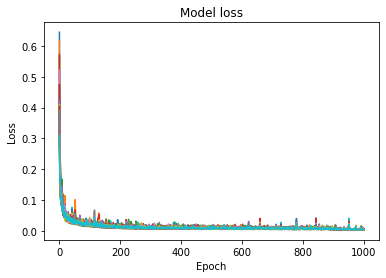

In [13]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [14]:
torch.tensor(loss_history).size()

torch.Size([1000, 50])

In [15]:
# save model
path = "./modelgpu_3200.pth"
torch.save(AEmodel.state_dict(), path)


In [16]:
# load model
AEmodel = Make_model()
AEmodel.load_state_dict(torch.load(path))
AEmodel.eval()


Make_model(
  (encoder): Encoder(
    (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(65, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(65, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv7): Conv2d(68, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv8): Conv2d(68, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (conv9): Conv2d(68, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv10): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv11): Conv2d(65, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (conv12): Conv2d(65, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv13): Conv2d(6

In [17]:
# 获取所有数据，计算并测试

labels  tensor([18, 18, 15,  0,  2,  7, 11,  8, 17,  5, 11,  9, 16,  4,  4,  5, 15, 12,
         9,  7, 12, 18,  6, 16, 15, 17, 18, 18, 12, 12,  1, 18,  3, 19,  1, 10,
        10,  7, 12, 16, 15, 15, 12,  6, 18, 19, 15,  3, 13, 15, 17, 18, 19,  6,
         0, 18, 10, 11,  1, 12,  7,  9,  6, 13])
images size =  torch.Size([64, 3, 64, 64])
images c size =  torch.Size([5, 3, 64, 64])
images s size =  torch.Size([5, 3, 64, 64])


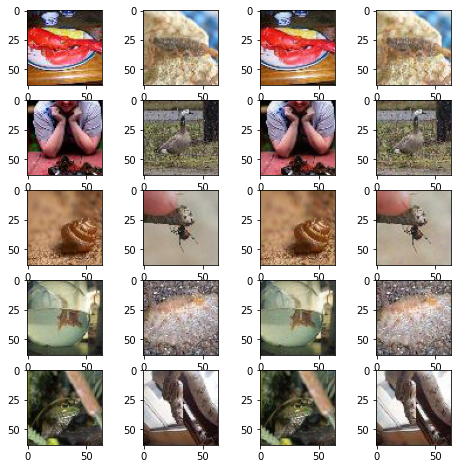

In [18]:
#随机显示一些图像
fig = plt.figure(figsize=(8,8)) #图像尺寸
colums = 4
rows = 5

#随机获取一个batch的图像
dataiter = iter(test_loader)
images,labels = dataiter.next()
#print("images ",images)
print("labels ",labels)
print("images size = ",images.size())

#将一个batch 一分为二，分为 C 与 S

input_C = images[0:5]
input_S = images[5:10]
print("images c size = ",input_C.size())
print("images s size = ",input_S.size())

for i in range(0,rows):
    fig.add_subplot(rows,colums,i*colums+1)
    
    img = input_C[i]/2 +0.5 #unnormalize
    npimg = img.numpy()
    #print('npimg:',npimg)
    plt.imshow(np.transpose(npimg,(1,2,0))) # 维度转换
    
    fig.add_subplot(rows,colums,i*colums+1+1)
    s_img = input_S[i]/2 +0.5
    npimg_s = s_img.numpy()
    #print('npimg_s:',npimg_s)
    plt.imshow(np.transpose(npimg_s,(1,2,0))) # 维度转换
    
    c_img_encode,s_img_decode = AEmodel(input_S[i].unsqueeze(0),input_C[i].unsqueeze(0)) # 获取编码图和密图
    
    fig.add_subplot(rows,colums,i*colums+2+1)
    c_img_encode = c_img_encode/2 +0.5
    npc_img_encode = c_img_encode.detach().squeeze().numpy()
    #print('npc_img_encode:',npc_img_encode)
    plt.imshow(np.transpose(npc_img_encode,(1,2,0))) # 维度转换
    
    fig.add_subplot(rows,colums,i*colums+3+1)
    s_img_decode = s_img_decode/2 +0.5
    nps_img_decode = s_img_decode.detach().squeeze().numpy()
    #print('nps_img_decode:',nps_img_decode)
    plt.imshow(np.transpose(nps_img_decode,(1,2,0))) # 维度转换
    
plt.show()